# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

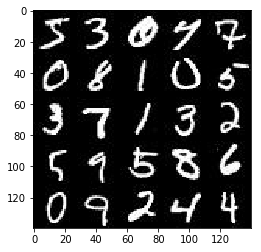

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

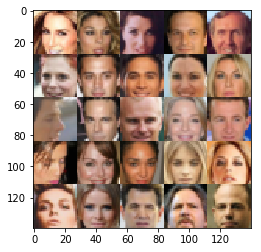

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, shape=[None,image_width,image_height,image_channels],
                                 name='input_images')
    z_input = tf.placeholder(tf.float32, shape = [None, z_dim], name = 'z_input')
    learning_rate = tf.placeholder(tf.float32)
    return input_images, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Leaky ReLU

Instead of implementing Leaky ReLU again and again I created this nice helper function

In [6]:
def leaky_relu(x, alpha = 0.1, name='leaky_relu'):
    return tf.maximum(alpha*x, x, name = name)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # input 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer = tf.contrib.layers.xavier_initializer())
        relu1 = leaky_relu(x1)
        #print(relu1.get_shape())
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer = tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = leaky_relu(x2)
        #print(relu2.get_shape())
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same', kernel_initializer = tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = leaky_relu(x3)
        relu3 = tf.nn.dropout(relu3, 0.8)
        #print(relu3.get_shape())
        
        flat = tf.reshape(relu3, (-1, 7*7*512))
        #print(flat.get_shape())
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [23]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha = 0.2
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        #print (x1.get_shape())
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides = 1, padding='same', kernel_initializer = tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        #print (x2.get_shape())
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides = 2, padding='same', kernel_initializer = tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        #print (x3.get_shape())
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides = 2, padding='same', kernel_initializer = tf.contrib.layers.xavier_initializer())
        #print(logits.get_shape())
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [32]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    smooth = 0.1
    
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [33]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    g_update_ops = [var for var in update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in update_ops if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
   
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [34]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [35]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2
                steps += 1
            
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    _ = show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3676... Generator Loss: 0.4920


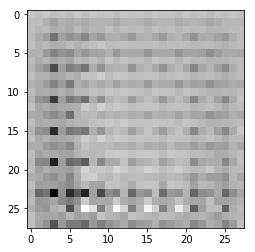

Epoch 1/2... Discriminator Loss: 1.2682... Generator Loss: 0.7110


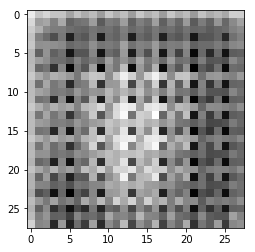

Epoch 1/2... Discriminator Loss: 1.1920... Generator Loss: 0.7490


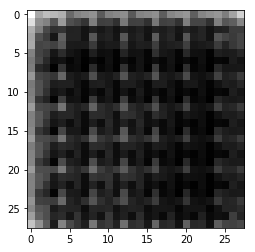

Epoch 1/2... Discriminator Loss: 1.4604... Generator Loss: 0.4964


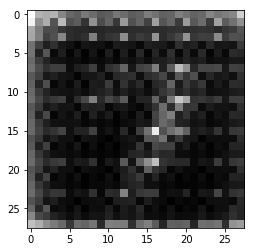

Epoch 1/2... Discriminator Loss: 1.3462... Generator Loss: 0.7059


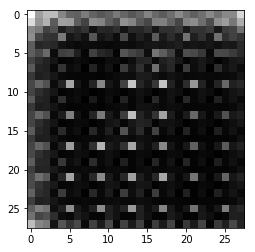

Epoch 1/2... Discriminator Loss: 1.3431... Generator Loss: 0.9322


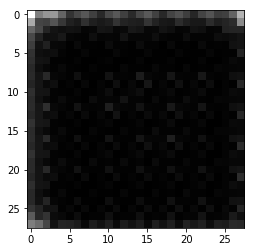

Epoch 1/2... Discriminator Loss: 1.3267... Generator Loss: 0.6847


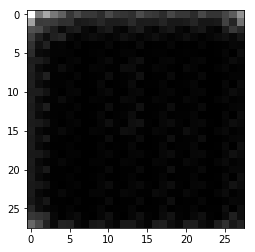

Epoch 1/2... Discriminator Loss: 1.3677... Generator Loss: 0.7204


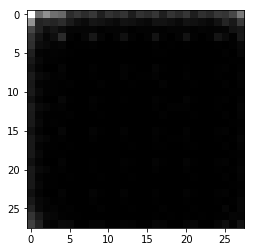

Epoch 1/2... Discriminator Loss: 1.3339... Generator Loss: 0.8265


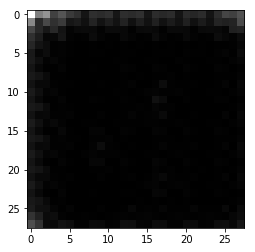

Epoch 1/2... Discriminator Loss: 1.4133... Generator Loss: 0.5846


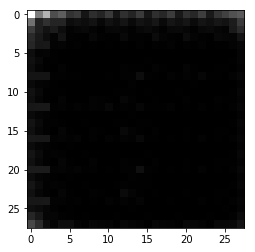

Epoch 1/2... Discriminator Loss: 1.3077... Generator Loss: 0.7865


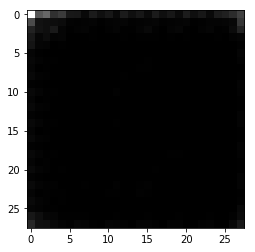

Epoch 1/2... Discriminator Loss: 1.3355... Generator Loss: 0.8133


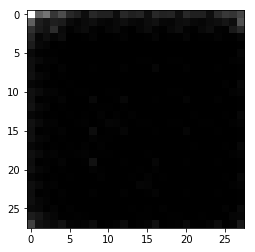

Epoch 1/2... Discriminator Loss: 1.4064... Generator Loss: 0.6805


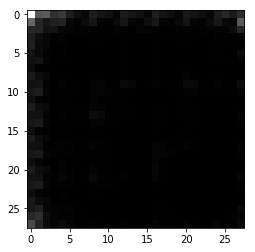

Epoch 1/2... Discriminator Loss: 1.3827... Generator Loss: 0.7879


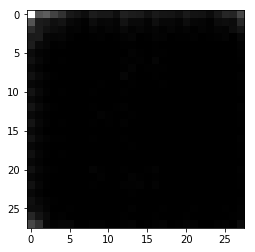

Epoch 1/2... Discriminator Loss: 1.4729... Generator Loss: 0.4999


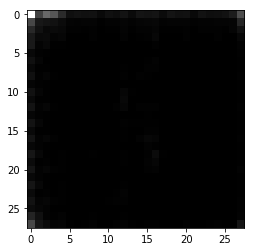

Epoch 1/2... Discriminator Loss: 1.4396... Generator Loss: 0.5679


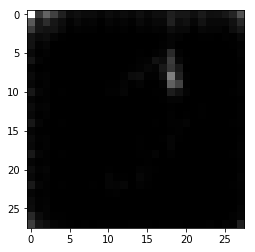

Epoch 1/2... Discriminator Loss: 1.3621... Generator Loss: 0.8960


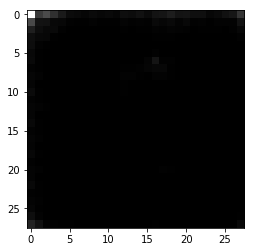

Epoch 1/2... Discriminator Loss: 1.3388... Generator Loss: 0.7551


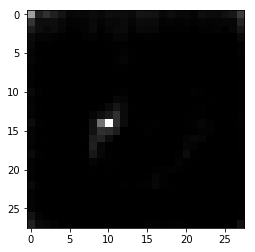

Epoch 1/2... Discriminator Loss: 1.3783... Generator Loss: 0.7642


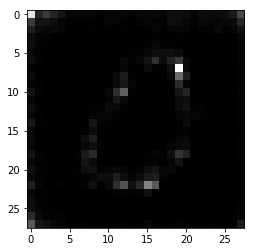

Epoch 1/2... Discriminator Loss: 1.4207... Generator Loss: 0.9167


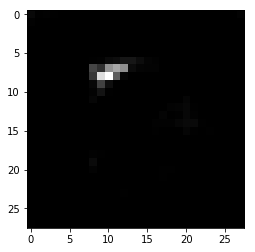

Epoch 1/2... Discriminator Loss: 1.2327... Generator Loss: 0.9744


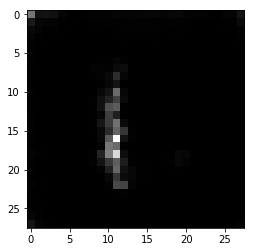

Epoch 1/2... Discriminator Loss: 1.5568... Generator Loss: 0.7742


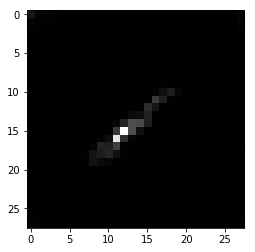

Epoch 1/2... Discriminator Loss: 1.3937... Generator Loss: 0.7079


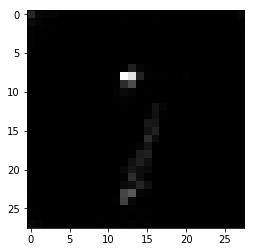

Epoch 1/2... Discriminator Loss: 1.3656... Generator Loss: 0.7078


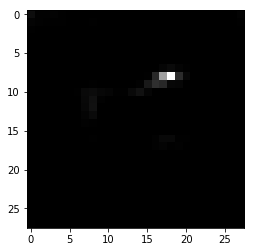

Epoch 1/2... Discriminator Loss: 1.3174... Generator Loss: 0.7855


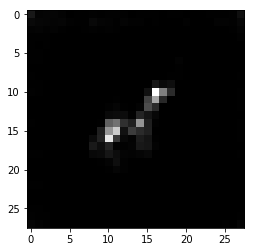

Epoch 1/2... Discriminator Loss: 1.3459... Generator Loss: 0.8798


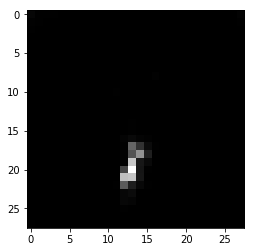

Epoch 1/2... Discriminator Loss: 1.4081... Generator Loss: 0.6629


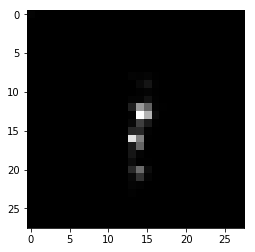

Epoch 1/2... Discriminator Loss: 1.4054... Generator Loss: 0.7317


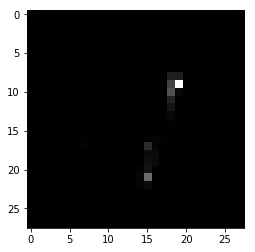

Epoch 1/2... Discriminator Loss: 1.3086... Generator Loss: 0.7106


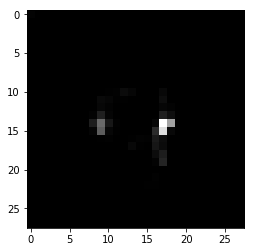

Epoch 1/2... Discriminator Loss: 1.3830... Generator Loss: 0.6993


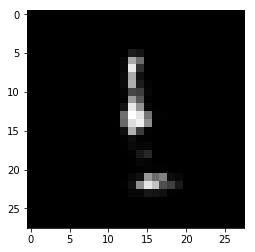

Epoch 1/2... Discriminator Loss: 1.3743... Generator Loss: 0.7419


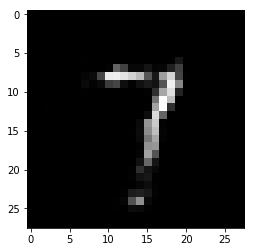

Epoch 1/2... Discriminator Loss: 1.3742... Generator Loss: 0.7449


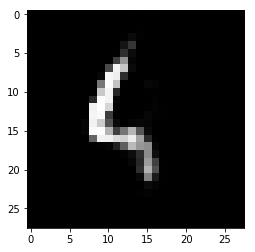

Epoch 1/2... Discriminator Loss: 1.4120... Generator Loss: 0.9921


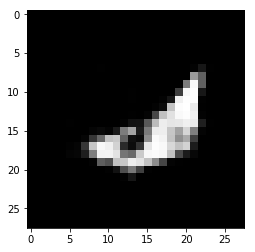

Epoch 1/2... Discriminator Loss: 1.3208... Generator Loss: 0.8065


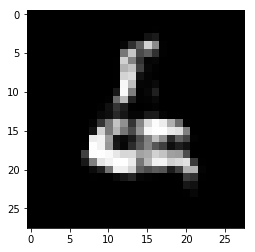

Epoch 1/2... Discriminator Loss: 1.6946... Generator Loss: 0.3352


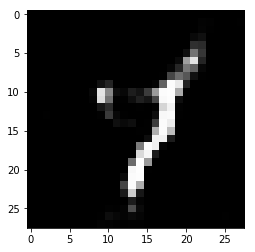

Epoch 1/2... Discriminator Loss: 1.3481... Generator Loss: 0.8015


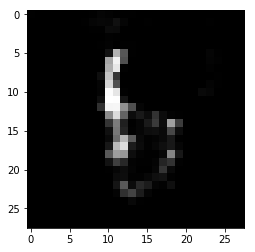

Epoch 1/2... Discriminator Loss: 1.3522... Generator Loss: 0.6985


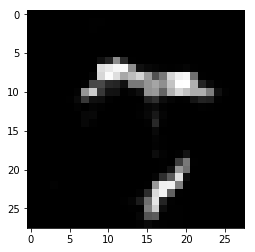

Epoch 1/2... Discriminator Loss: 1.5519... Generator Loss: 0.3943


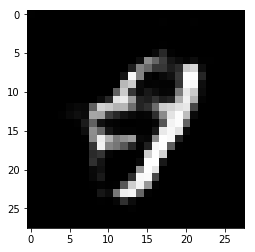

Epoch 1/2... Discriminator Loss: 1.3695... Generator Loss: 0.7509


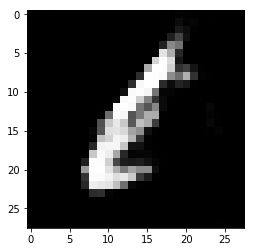

Epoch 1/2... Discriminator Loss: 1.4872... Generator Loss: 0.5549


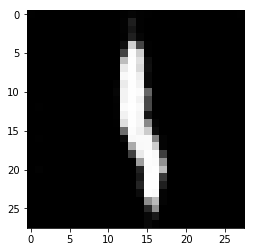

Epoch 1/2... Discriminator Loss: 1.3340... Generator Loss: 0.7265


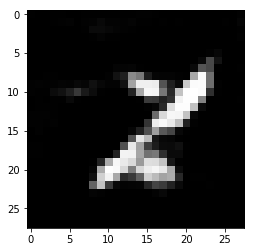

Epoch 1/2... Discriminator Loss: 1.3430... Generator Loss: 0.7010


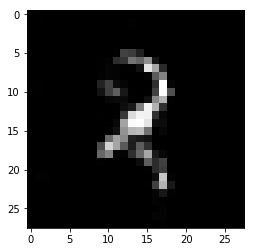

Epoch 1/2... Discriminator Loss: 1.3002... Generator Loss: 0.8001


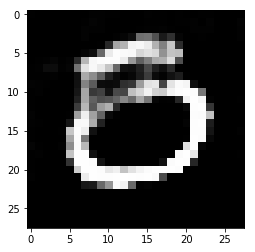

Epoch 1/2... Discriminator Loss: 1.3817... Generator Loss: 0.6307


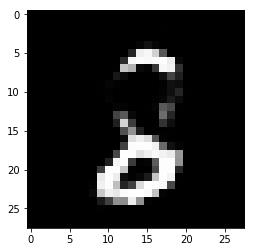

Epoch 1/2... Discriminator Loss: 1.4584... Generator Loss: 0.5197


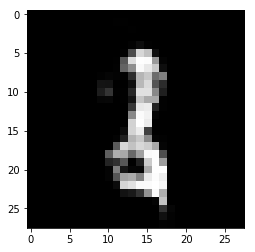

Epoch 1/2... Discriminator Loss: 1.3120... Generator Loss: 0.6891


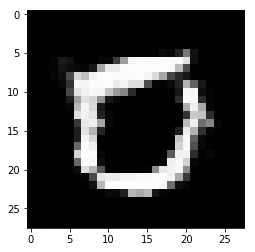

Epoch 1/2... Discriminator Loss: 1.3484... Generator Loss: 0.6910


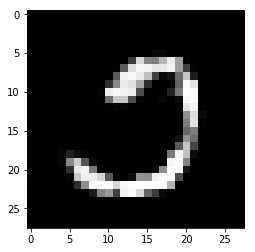

Epoch 1/2... Discriminator Loss: 1.3828... Generator Loss: 0.7801


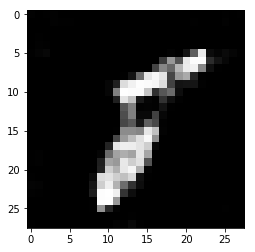

Epoch 1/2... Discriminator Loss: 1.2379... Generator Loss: 0.8602


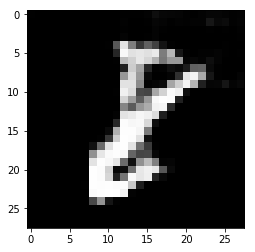

Epoch 1/2... Discriminator Loss: 1.3113... Generator Loss: 0.8622


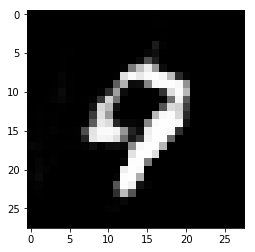

Epoch 1/2... Discriminator Loss: 1.3793... Generator Loss: 0.7297


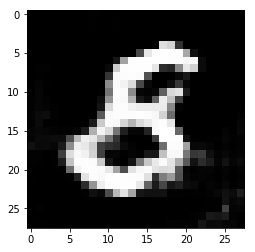

Epoch 1/2... Discriminator Loss: 1.3453... Generator Loss: 0.6996


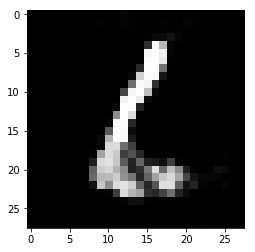

Epoch 1/2... Discriminator Loss: 1.4032... Generator Loss: 0.9891


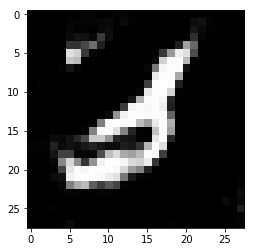

Epoch 1/2... Discriminator Loss: 1.3109... Generator Loss: 1.0891


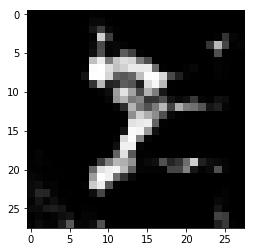

Epoch 1/2... Discriminator Loss: 1.3016... Generator Loss: 0.9267


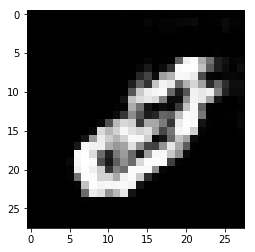

Epoch 1/2... Discriminator Loss: 1.3279... Generator Loss: 0.8637


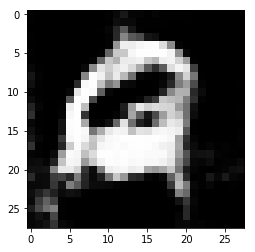

Epoch 1/2... Discriminator Loss: 1.4194... Generator Loss: 0.5181


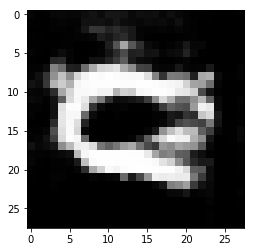

Epoch 1/2... Discriminator Loss: 1.3212... Generator Loss: 0.7806


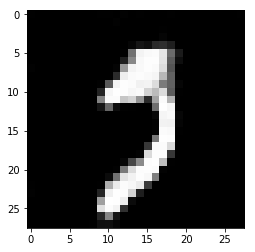

Epoch 1/2... Discriminator Loss: 1.2768... Generator Loss: 0.7042


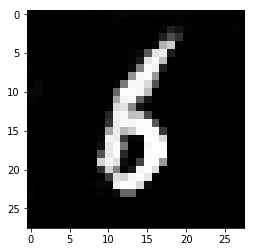

Epoch 1/2... Discriminator Loss: 1.1878... Generator Loss: 0.9797


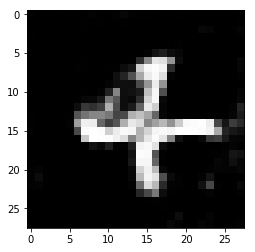

Epoch 1/2... Discriminator Loss: 1.3967... Generator Loss: 0.5775


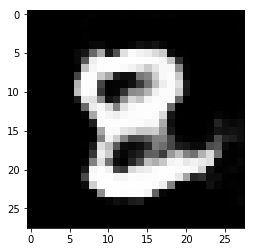

Epoch 1/2... Discriminator Loss: 1.3581... Generator Loss: 0.5757


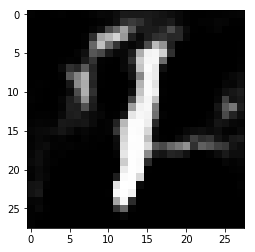

Epoch 1/2... Discriminator Loss: 1.3022... Generator Loss: 0.6818


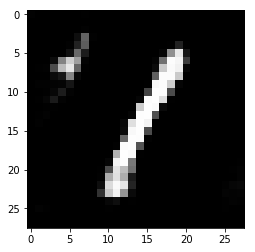

Epoch 1/2... Discriminator Loss: 1.3297... Generator Loss: 1.2327


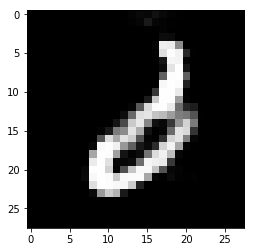

Epoch 1/2... Discriminator Loss: 1.2555... Generator Loss: 0.7739


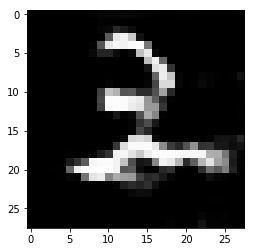

Epoch 1/2... Discriminator Loss: 1.2042... Generator Loss: 0.8575


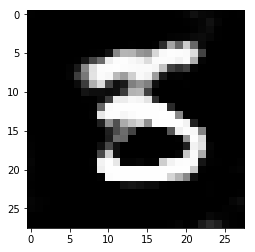

Epoch 1/2... Discriminator Loss: 1.2824... Generator Loss: 0.9262


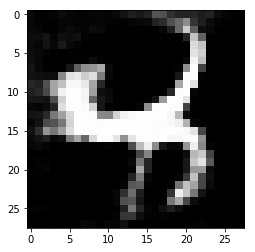

Epoch 1/2... Discriminator Loss: 1.3840... Generator Loss: 0.5531


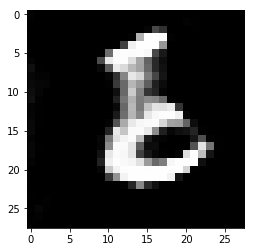

Epoch 1/2... Discriminator Loss: 1.3202... Generator Loss: 0.7374


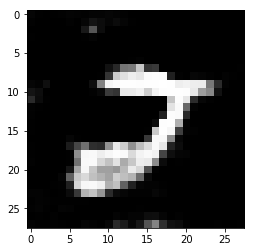

Epoch 1/2... Discriminator Loss: 1.3386... Generator Loss: 0.6165


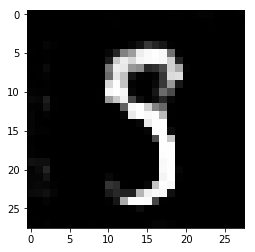

Epoch 1/2... Discriminator Loss: 1.2876... Generator Loss: 0.7100


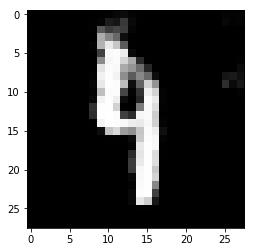

Epoch 1/2... Discriminator Loss: 1.3208... Generator Loss: 0.7668


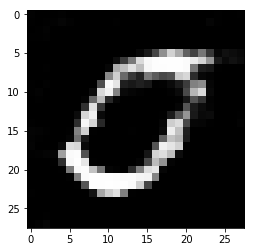

Epoch 1/2... Discriminator Loss: 1.3106... Generator Loss: 0.9830


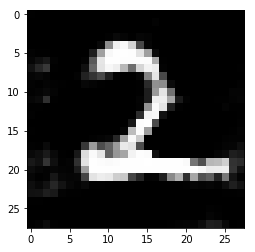

Epoch 1/2... Discriminator Loss: 1.1553... Generator Loss: 0.9405


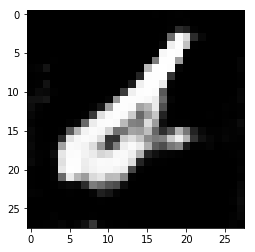

Epoch 1/2... Discriminator Loss: 1.3051... Generator Loss: 0.6217


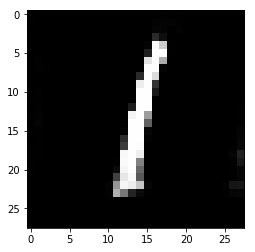

Epoch 1/2... Discriminator Loss: 1.2292... Generator Loss: 0.9546


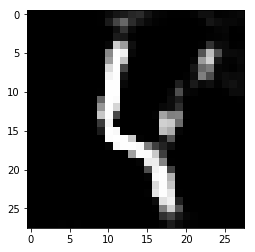

Epoch 1/2... Discriminator Loss: 1.2223... Generator Loss: 0.8654


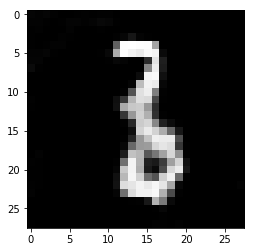

Epoch 1/2... Discriminator Loss: 1.2151... Generator Loss: 0.7753


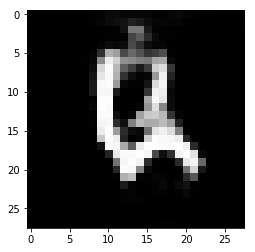

Epoch 1/2... Discriminator Loss: 1.3137... Generator Loss: 0.7070


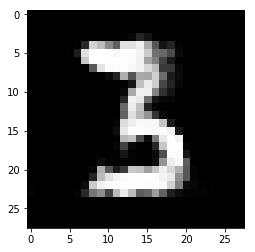

Epoch 1/2... Discriminator Loss: 1.2363... Generator Loss: 0.9419


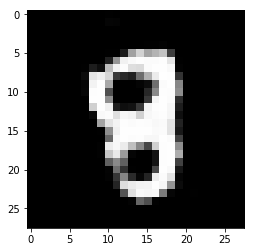

Epoch 1/2... Discriminator Loss: 1.3141... Generator Loss: 0.7362


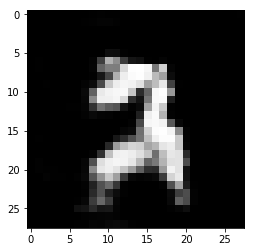

Epoch 1/2... Discriminator Loss: 1.2144... Generator Loss: 0.8563


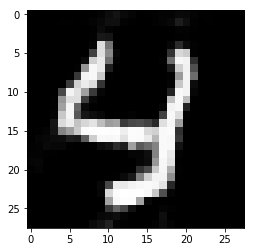

Epoch 1/2... Discriminator Loss: 1.3753... Generator Loss: 0.6720


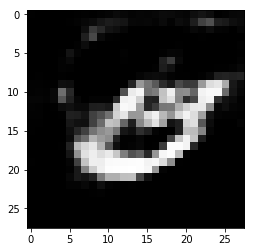

Epoch 1/2... Discriminator Loss: 1.1696... Generator Loss: 1.5976


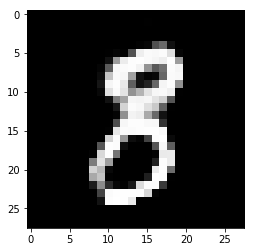

Epoch 1/2... Discriminator Loss: 1.1241... Generator Loss: 0.9189


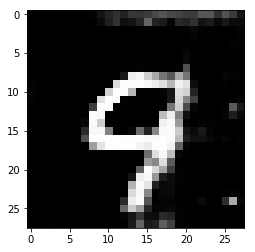

Epoch 1/2... Discriminator Loss: 1.2830... Generator Loss: 0.6235


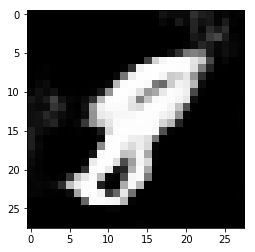

Epoch 1/2... Discriminator Loss: 1.2979... Generator Loss: 0.8361


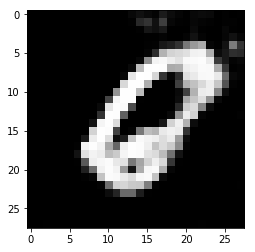

Epoch 1/2... Discriminator Loss: 1.3466... Generator Loss: 0.8168


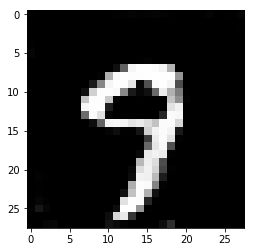

Epoch 1/2... Discriminator Loss: 1.1956... Generator Loss: 1.0163


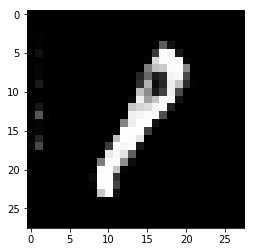

Epoch 1/2... Discriminator Loss: 1.2189... Generator Loss: 0.8043


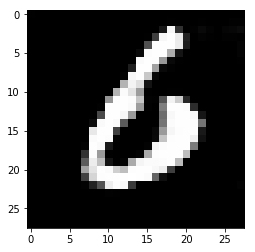

Epoch 1/2... Discriminator Loss: 1.2849... Generator Loss: 0.7497


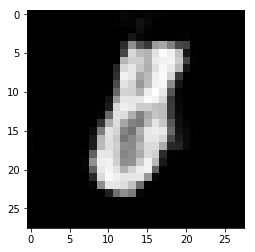

Epoch 1/2... Discriminator Loss: 1.2296... Generator Loss: 0.9703


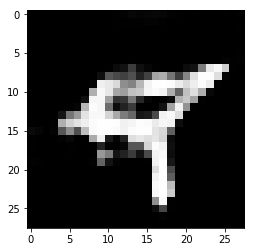

Epoch 1/2... Discriminator Loss: 1.3419... Generator Loss: 0.8615


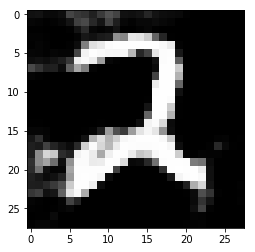

Epoch 2/2... Discriminator Loss: 1.2395... Generator Loss: 0.6775


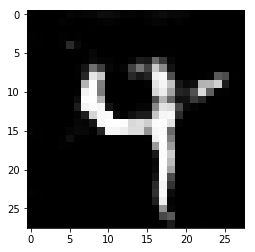

Epoch 2/2... Discriminator Loss: 1.2068... Generator Loss: 0.8768


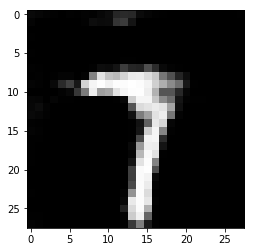

Epoch 2/2... Discriminator Loss: 1.2762... Generator Loss: 0.7178


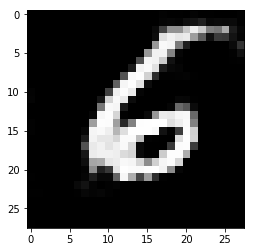

Epoch 2/2... Discriminator Loss: 1.2904... Generator Loss: 1.0878


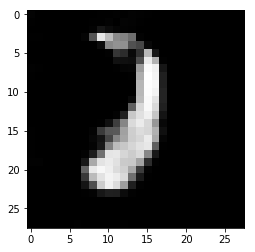

Epoch 2/2... Discriminator Loss: 1.2642... Generator Loss: 0.9907


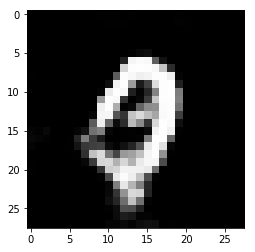

Epoch 2/2... Discriminator Loss: 1.2151... Generator Loss: 0.7035


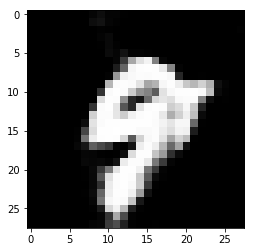

Epoch 2/2... Discriminator Loss: 1.0822... Generator Loss: 0.9364


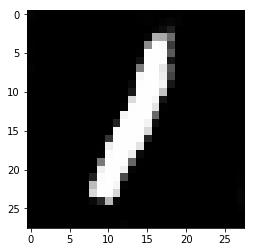

Epoch 2/2... Discriminator Loss: 1.1447... Generator Loss: 0.7970


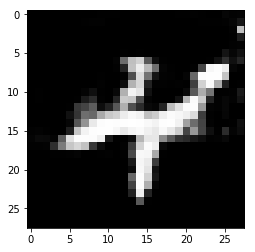

Epoch 2/2... Discriminator Loss: 1.2077... Generator Loss: 0.7532


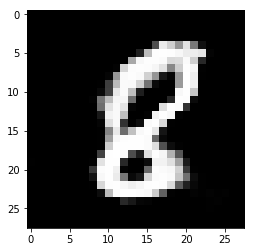

Epoch 2/2... Discriminator Loss: 1.1736... Generator Loss: 1.1350


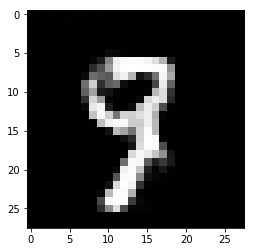

Epoch 2/2... Discriminator Loss: 1.3566... Generator Loss: 0.5468


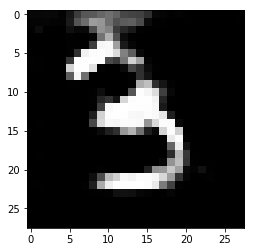

Epoch 2/2... Discriminator Loss: 1.2097... Generator Loss: 0.8876


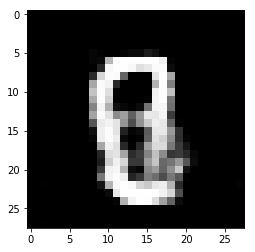

Epoch 2/2... Discriminator Loss: 1.3469... Generator Loss: 0.6440


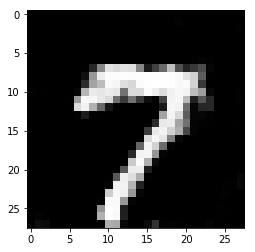

Epoch 2/2... Discriminator Loss: 1.3206... Generator Loss: 0.7289


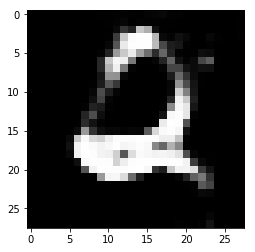

Epoch 2/2... Discriminator Loss: 1.1545... Generator Loss: 0.9996


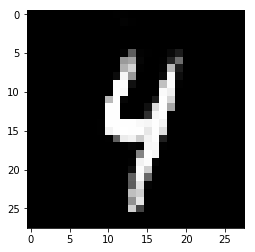

Epoch 2/2... Discriminator Loss: 1.3539... Generator Loss: 0.5837


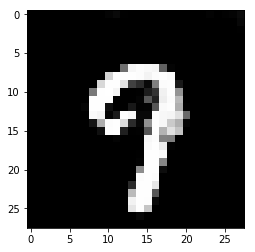

Epoch 2/2... Discriminator Loss: 2.4312... Generator Loss: 0.1619


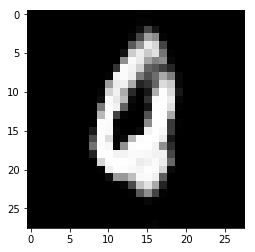

Epoch 2/2... Discriminator Loss: 1.0011... Generator Loss: 1.0334


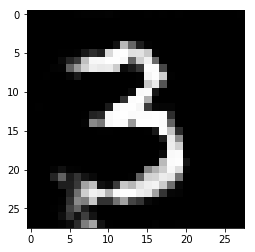

Epoch 2/2... Discriminator Loss: 1.2856... Generator Loss: 0.6249


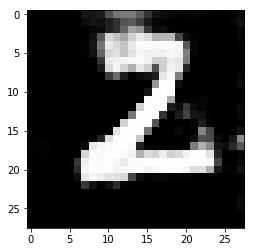

Epoch 2/2... Discriminator Loss: 1.1908... Generator Loss: 0.8363


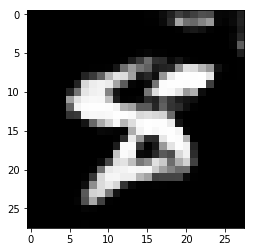

Epoch 2/2... Discriminator Loss: 1.1407... Generator Loss: 1.0518


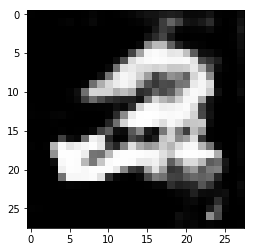

Epoch 2/2... Discriminator Loss: 1.3672... Generator Loss: 0.6204


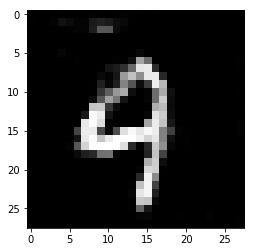

Epoch 2/2... Discriminator Loss: 1.2663... Generator Loss: 0.6815


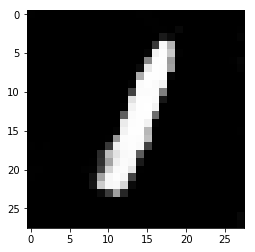

Epoch 2/2... Discriminator Loss: 1.1574... Generator Loss: 1.3890


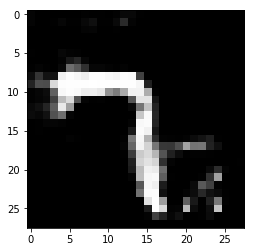

Epoch 2/2... Discriminator Loss: 1.2754... Generator Loss: 0.7397


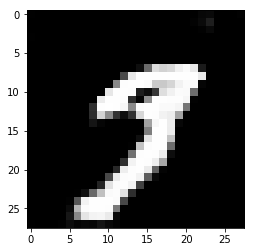

Epoch 2/2... Discriminator Loss: 1.1658... Generator Loss: 0.7535


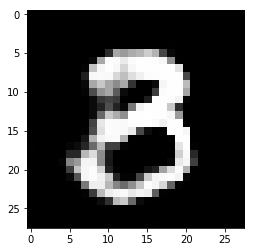

Epoch 2/2... Discriminator Loss: 1.2150... Generator Loss: 0.6860


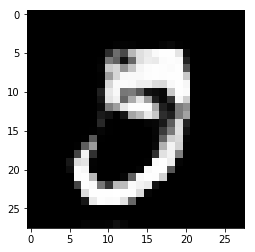

Epoch 2/2... Discriminator Loss: 1.2414... Generator Loss: 0.7634


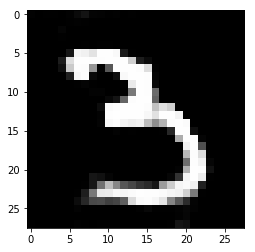

Epoch 2/2... Discriminator Loss: 1.0863... Generator Loss: 0.9370


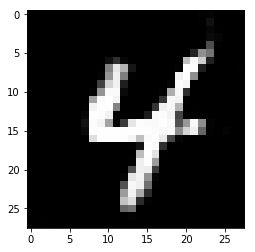

Epoch 2/2... Discriminator Loss: 1.1690... Generator Loss: 0.8728


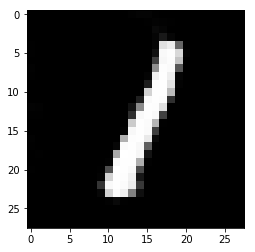

Epoch 2/2... Discriminator Loss: 1.1818... Generator Loss: 0.7977


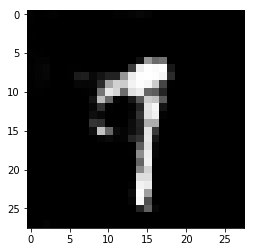

Epoch 2/2... Discriminator Loss: 1.2717... Generator Loss: 0.7544


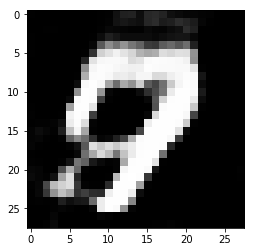

Epoch 2/2... Discriminator Loss: 1.1995... Generator Loss: 1.3538


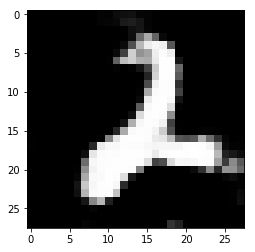

Epoch 2/2... Discriminator Loss: 1.1192... Generator Loss: 1.1279


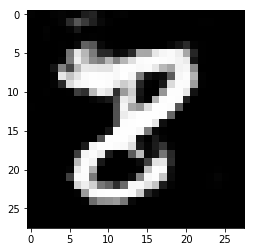

Epoch 2/2... Discriminator Loss: 1.1630... Generator Loss: 0.9045


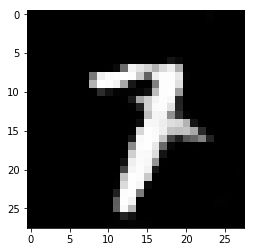

Epoch 2/2... Discriminator Loss: 1.0848... Generator Loss: 0.9985


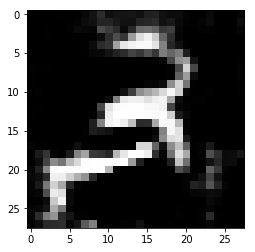

Epoch 2/2... Discriminator Loss: 1.5855... Generator Loss: 1.9728


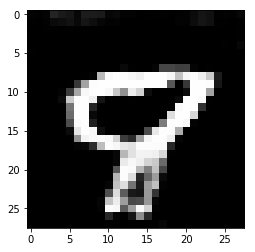

Epoch 2/2... Discriminator Loss: 1.3693... Generator Loss: 0.6454


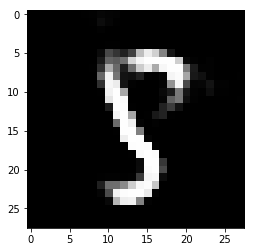

Epoch 2/2... Discriminator Loss: 1.3640... Generator Loss: 1.2068


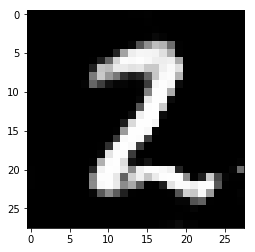

Epoch 2/2... Discriminator Loss: 1.2122... Generator Loss: 0.7399


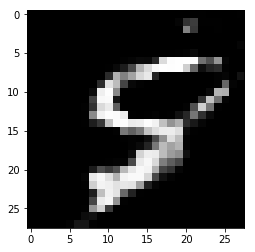

Epoch 2/2... Discriminator Loss: 1.2009... Generator Loss: 1.0773


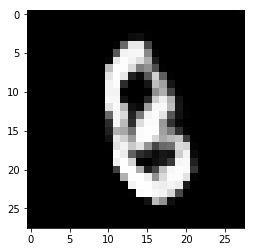

Epoch 2/2... Discriminator Loss: 1.1176... Generator Loss: 0.8670


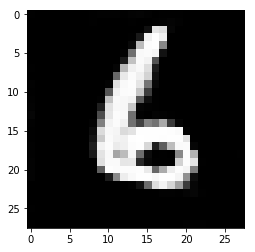

Epoch 2/2... Discriminator Loss: 1.2219... Generator Loss: 0.7112


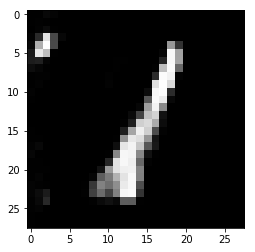

Epoch 2/2... Discriminator Loss: 1.2002... Generator Loss: 0.7726


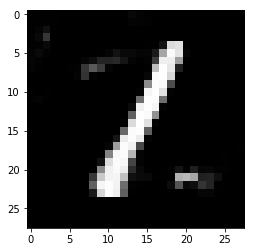

Epoch 2/2... Discriminator Loss: 1.2069... Generator Loss: 0.8564


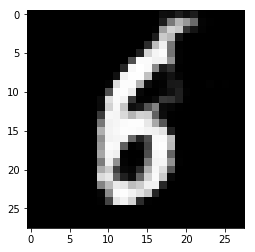

Epoch 2/2... Discriminator Loss: 1.3054... Generator Loss: 0.7917


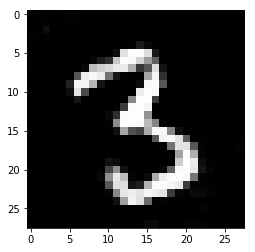

Epoch 2/2... Discriminator Loss: 1.1094... Generator Loss: 0.9050


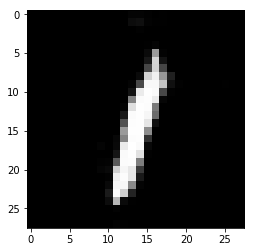

Epoch 2/2... Discriminator Loss: 1.0289... Generator Loss: 1.0549


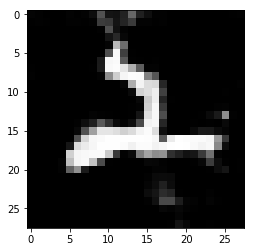

Epoch 2/2... Discriminator Loss: 1.2119... Generator Loss: 0.9472


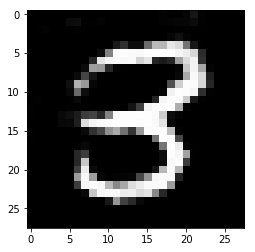

Epoch 2/2... Discriminator Loss: 1.2327... Generator Loss: 0.7483


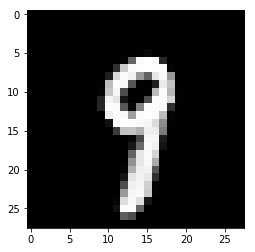

Epoch 2/2... Discriminator Loss: 1.3127... Generator Loss: 0.5797


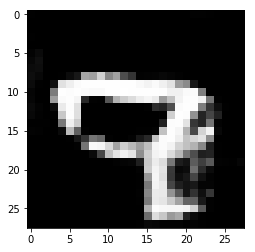

Epoch 2/2... Discriminator Loss: 1.5853... Generator Loss: 0.4035


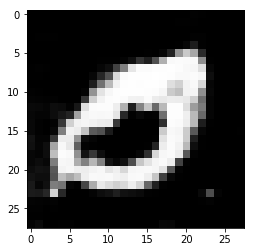

Epoch 2/2... Discriminator Loss: 1.1286... Generator Loss: 0.9560


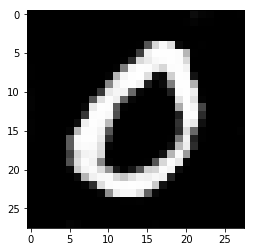

Epoch 2/2... Discriminator Loss: 1.3472... Generator Loss: 0.6418


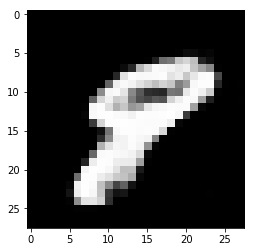

Epoch 2/2... Discriminator Loss: 1.0872... Generator Loss: 1.0796


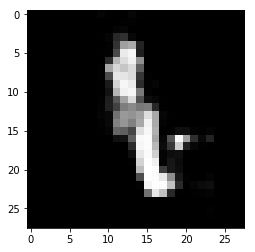

Epoch 2/2... Discriminator Loss: 1.1666... Generator Loss: 1.0347


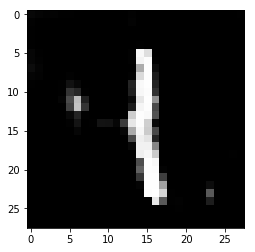

Epoch 2/2... Discriminator Loss: 1.6255... Generator Loss: 0.3984


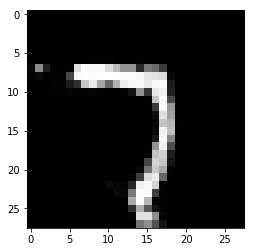

Epoch 2/2... Discriminator Loss: 1.3115... Generator Loss: 1.9909


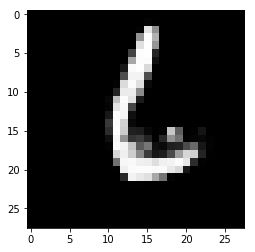

Epoch 2/2... Discriminator Loss: 1.1970... Generator Loss: 0.8883


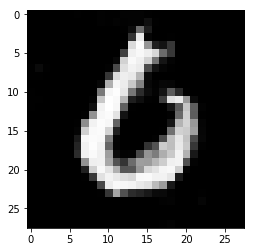

Epoch 2/2... Discriminator Loss: 0.9863... Generator Loss: 1.1426


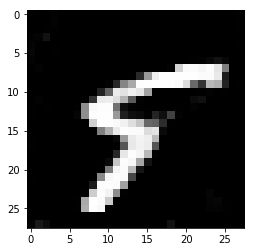

Epoch 2/2... Discriminator Loss: 1.1898... Generator Loss: 1.5763


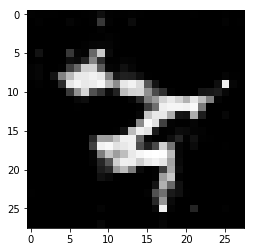

Epoch 2/2... Discriminator Loss: 1.1535... Generator Loss: 1.3236


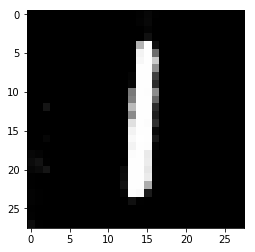

Epoch 2/2... Discriminator Loss: 1.1857... Generator Loss: 0.8427


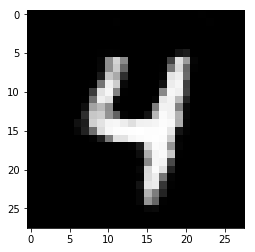

Epoch 2/2... Discriminator Loss: 1.2588... Generator Loss: 0.6307


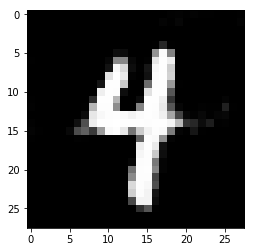

Epoch 2/2... Discriminator Loss: 1.0715... Generator Loss: 1.1569


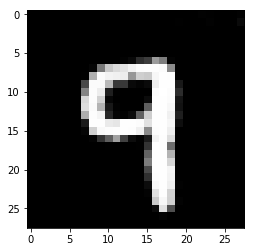

Epoch 2/2... Discriminator Loss: 1.2266... Generator Loss: 1.0074


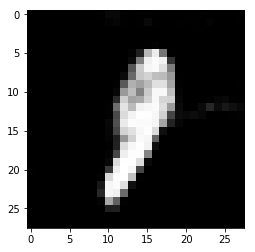

Epoch 2/2... Discriminator Loss: 1.1708... Generator Loss: 0.7623


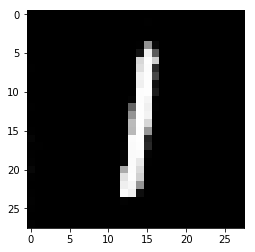

Epoch 2/2... Discriminator Loss: 1.1838... Generator Loss: 0.7636


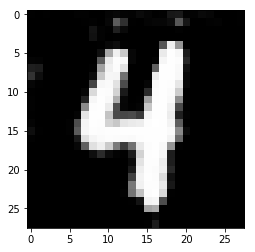

Epoch 2/2... Discriminator Loss: 1.0767... Generator Loss: 1.2017


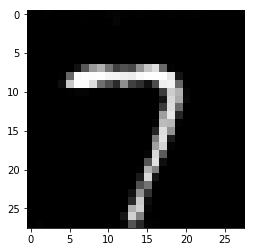

Epoch 2/2... Discriminator Loss: 1.3066... Generator Loss: 0.6100


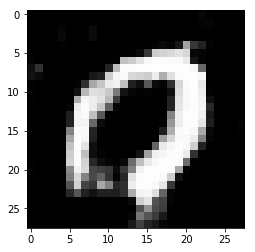

Epoch 2/2... Discriminator Loss: 1.1138... Generator Loss: 1.0038


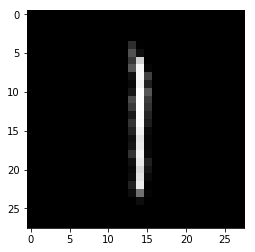

Epoch 2/2... Discriminator Loss: 1.1533... Generator Loss: 1.4247


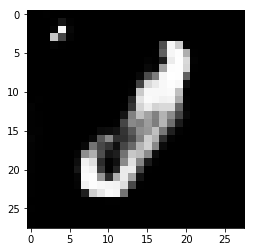

Epoch 2/2... Discriminator Loss: 1.0178... Generator Loss: 0.9307


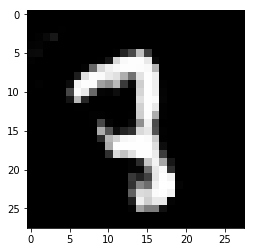

Epoch 2/2... Discriminator Loss: 1.6126... Generator Loss: 0.4518


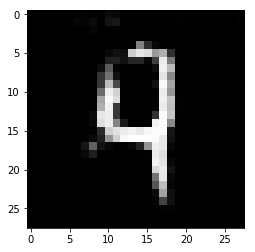

Epoch 2/2... Discriminator Loss: 1.0715... Generator Loss: 1.0958


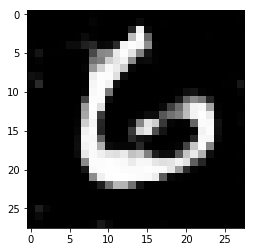

Epoch 2/2... Discriminator Loss: 1.1740... Generator Loss: 1.2587


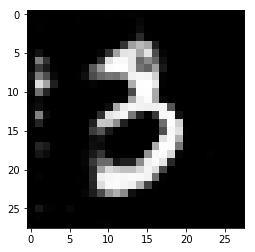

Epoch 2/2... Discriminator Loss: 1.4489... Generator Loss: 0.5004


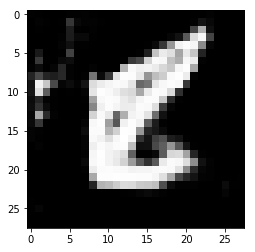

Epoch 2/2... Discriminator Loss: 1.1424... Generator Loss: 0.8234


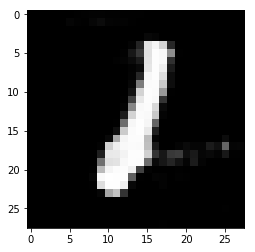

Epoch 2/2... Discriminator Loss: 1.2186... Generator Loss: 1.8172


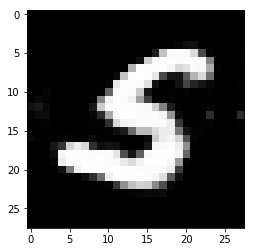

Epoch 2/2... Discriminator Loss: 1.0687... Generator Loss: 1.0335


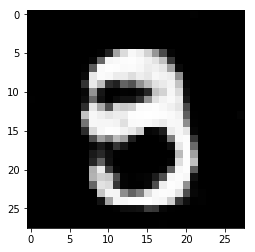

Epoch 2/2... Discriminator Loss: 1.1919... Generator Loss: 0.7087


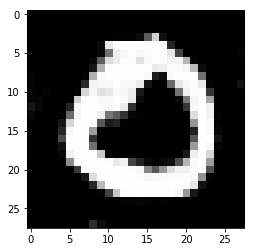

Epoch 2/2... Discriminator Loss: 1.1686... Generator Loss: 0.7532


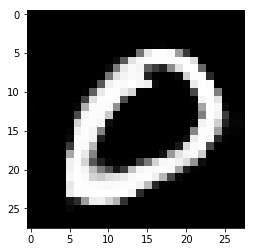

Epoch 2/2... Discriminator Loss: 1.1872... Generator Loss: 0.7286


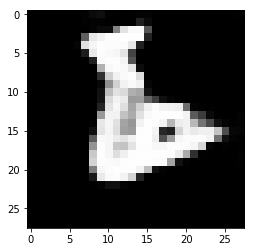

Epoch 2/2... Discriminator Loss: 1.1756... Generator Loss: 0.7039


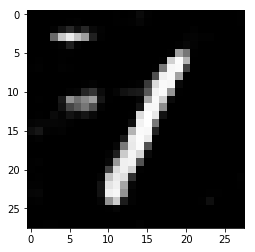

Epoch 2/2... Discriminator Loss: 1.3384... Generator Loss: 0.5465


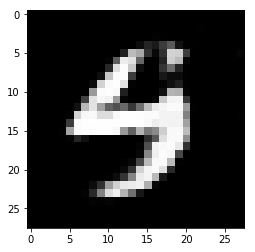

Epoch 2/2... Discriminator Loss: 1.1374... Generator Loss: 0.8234


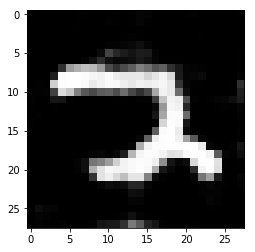

Epoch 2/2... Discriminator Loss: 1.1535... Generator Loss: 0.9876


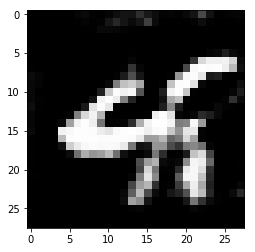

Epoch 2/2... Discriminator Loss: 1.0685... Generator Loss: 0.9281


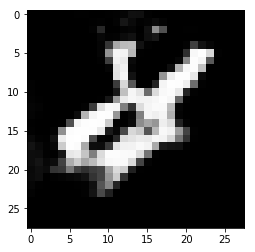

Epoch 2/2... Discriminator Loss: 1.1239... Generator Loss: 1.7852


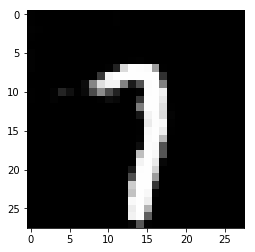

Epoch 2/2... Discriminator Loss: 1.0510... Generator Loss: 0.9922


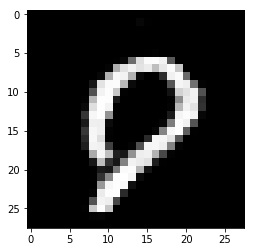

Epoch 2/2... Discriminator Loss: 1.3018... Generator Loss: 0.6806


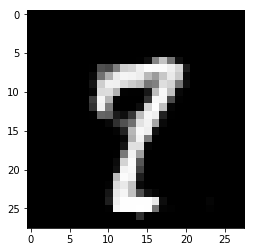

Epoch 2/2... Discriminator Loss: 1.2684... Generator Loss: 0.6280


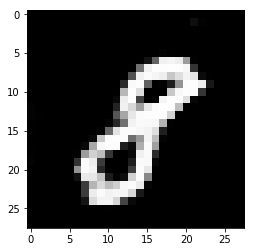

Epoch 2/2... Discriminator Loss: 1.0535... Generator Loss: 0.9420


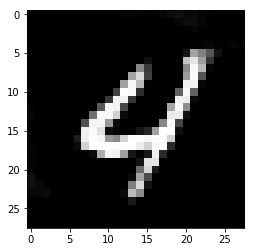

Epoch 2/2... Discriminator Loss: 1.0909... Generator Loss: 0.8448


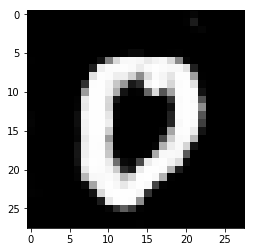

In [38]:
batch_size = 64
z_dim = 100
learning_rate = 0.0006
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 0.7022


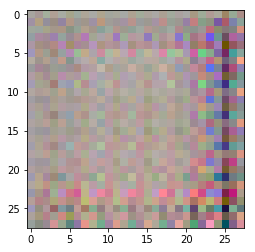

Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 0.7892


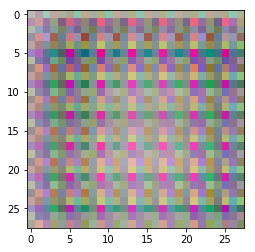

Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.6904


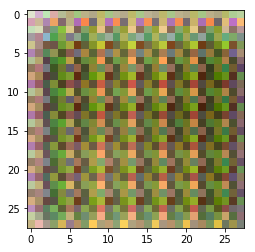

Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.7470


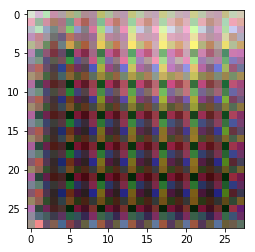

Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.7881


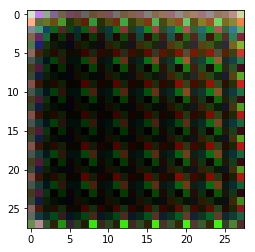

Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.7222


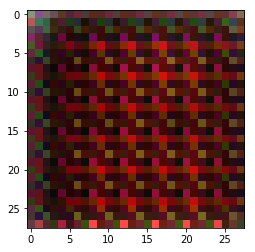

Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.6267


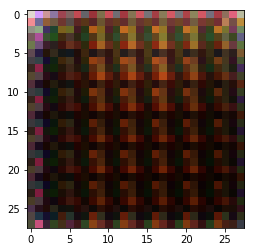

Epoch 1/1... Discriminator Loss: 1.2443... Generator Loss: 0.8791


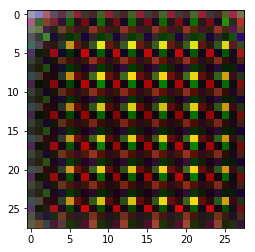

Epoch 1/1... Discriminator Loss: 0.9537... Generator Loss: 1.4789


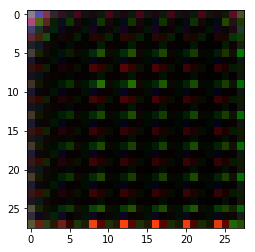

Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.9346


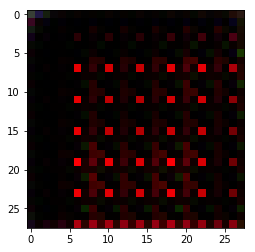

Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.7290


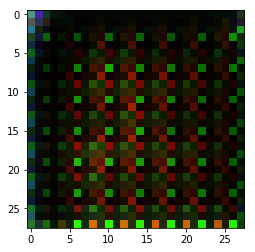

Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 0.7743


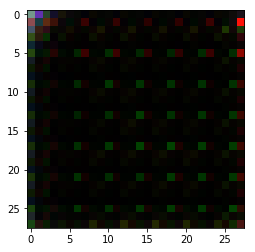

Epoch 1/1... Discriminator Loss: 0.7041... Generator Loss: 1.4725


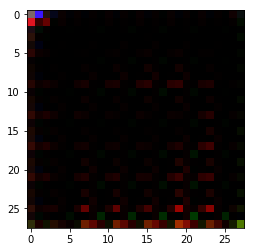

Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 1.2167


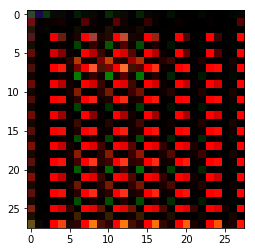

Epoch 1/1... Discriminator Loss: 1.1834... Generator Loss: 0.8480


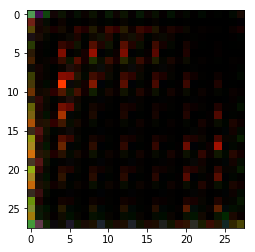

Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.7684


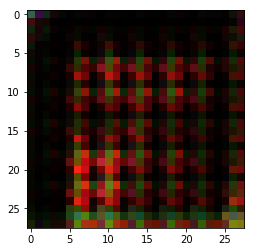

Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.7384


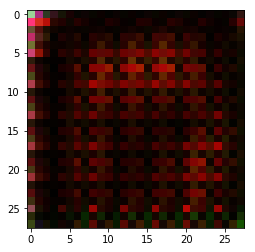

Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.8573


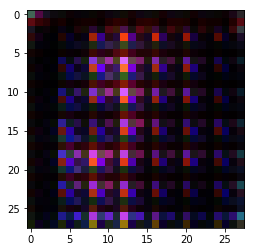

Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 1.3125


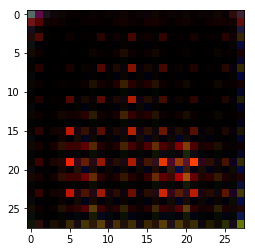

Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.8231


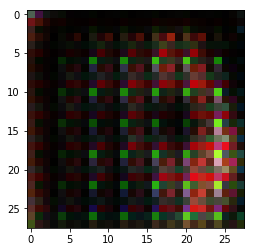

Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 1.2491


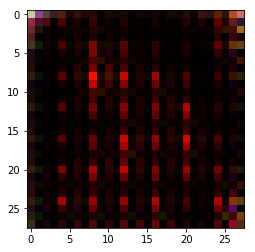

Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 0.9665


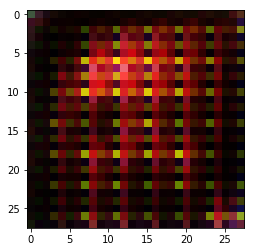

Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.8495


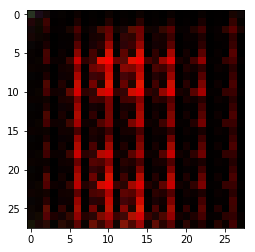

Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.7124


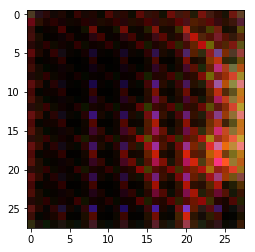

Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.9691


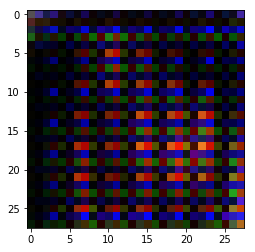

Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.8291


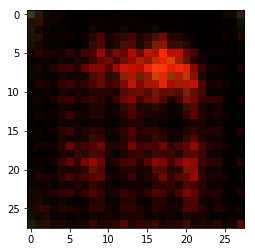

Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.7786


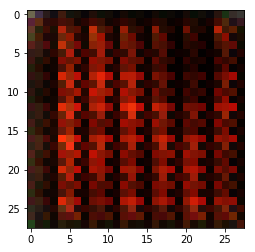

Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.9300


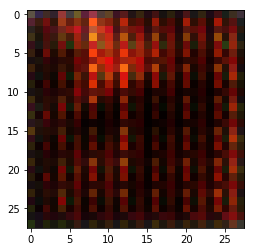

Epoch 1/1... Discriminator Loss: 1.5187... Generator Loss: 0.4490


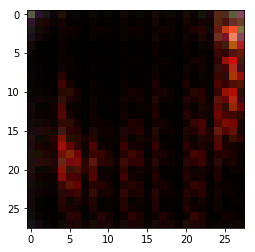

Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.8003


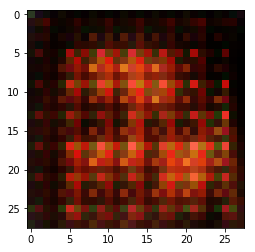

Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.7783


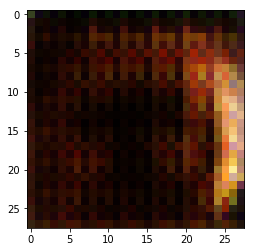

Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.7987


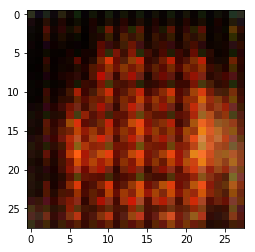

Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.4982


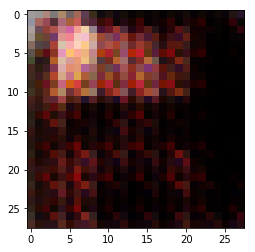

Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.8796


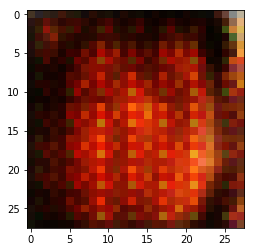

Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.8370


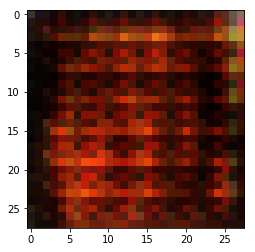

Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.7474


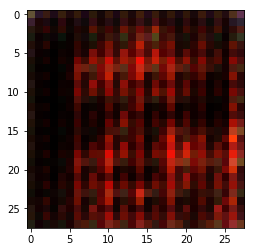

Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.7251


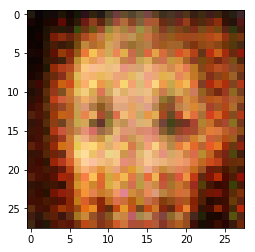

Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.8042


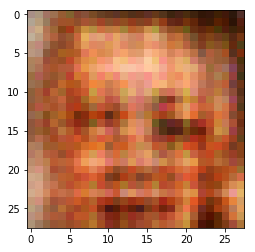

Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.5656


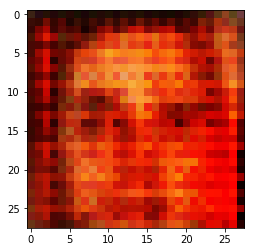

Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.8415


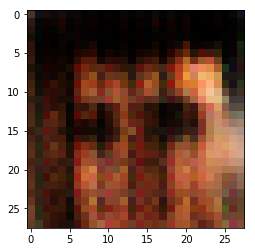

Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.8046


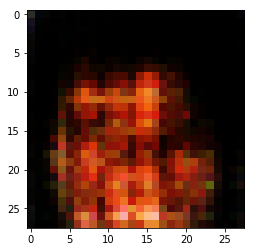

Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.7748


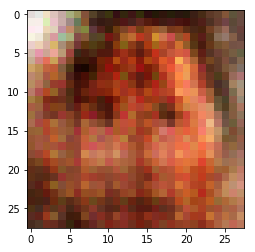

Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.7206


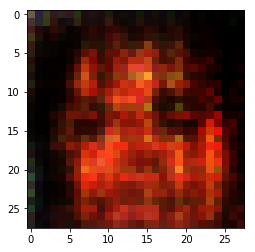

Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.5124


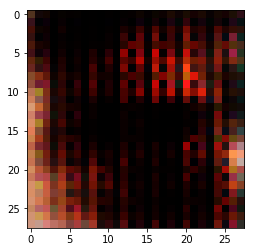

Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.8799


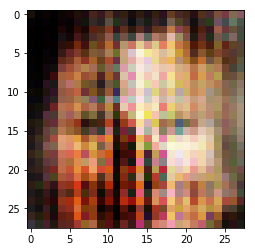

Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.9200


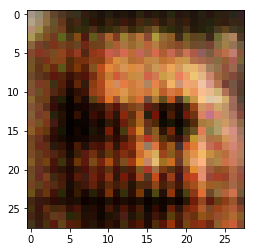

Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.8583


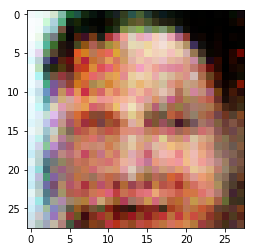

Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.8821


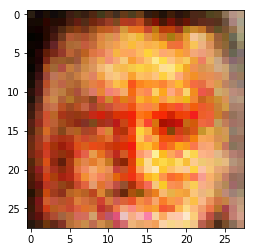

Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.7688


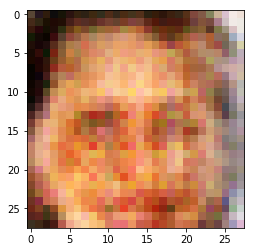

Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.7854


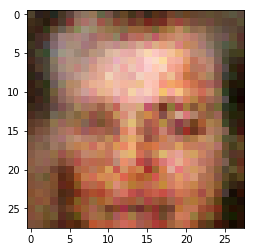

Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.7038


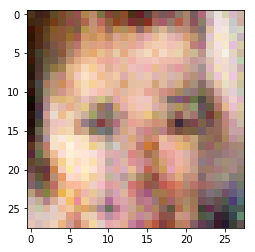

Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.7546


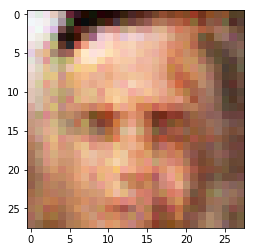

Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.8473


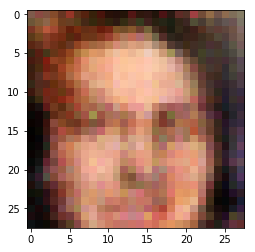

Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.8110


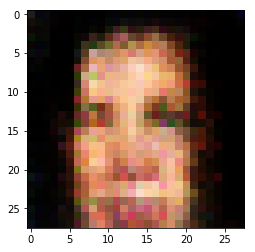

Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.7878


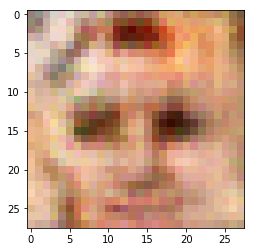

Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.7111


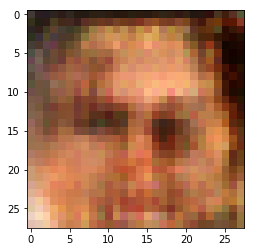

Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7685


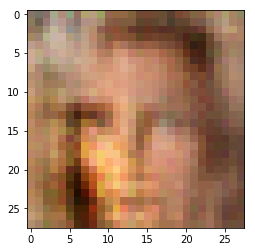

Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.8803


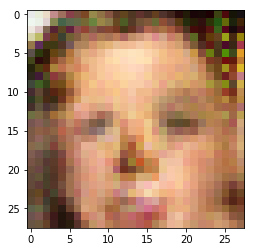

Epoch 1/1... Discriminator Loss: 1.3077... Generator Loss: 0.7773


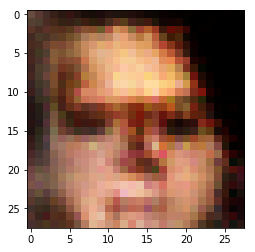

Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.8058


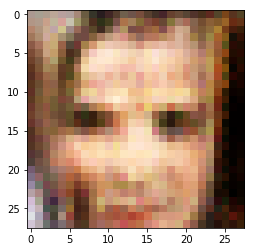

Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.7776


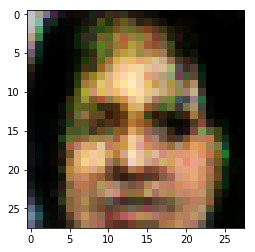

Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.5079


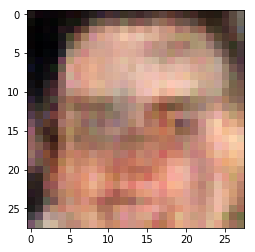

Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7398


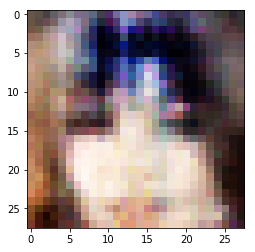

Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.7328


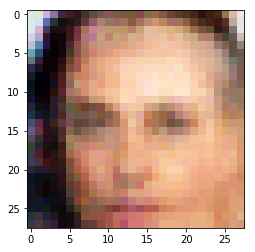

Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.7582


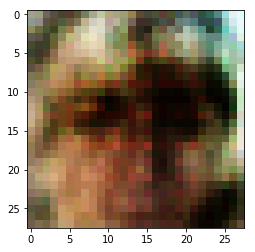

Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.7763


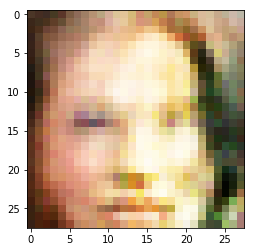

Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.8118


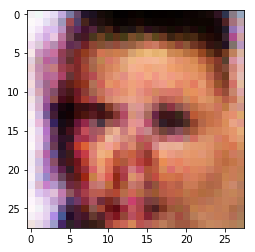

Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.8464


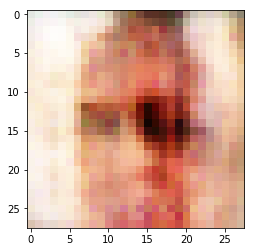

Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.7831


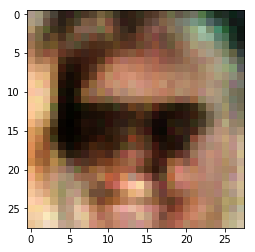

Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.7825


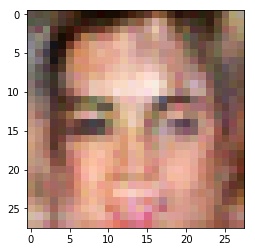

Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.7234


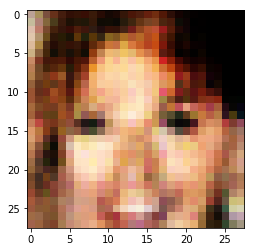

Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.7771


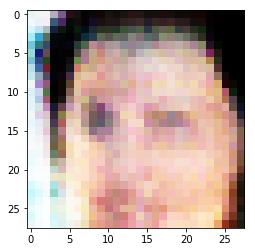

Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.8210


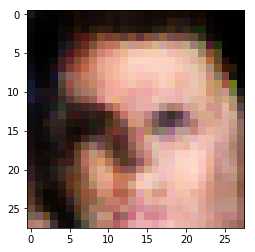

Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.8012


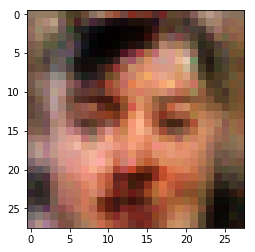

Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.7611


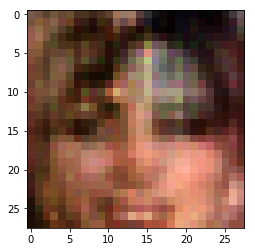

Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.7535


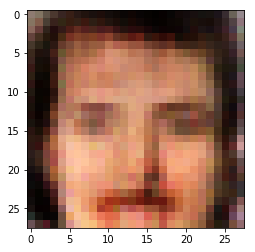

Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.7206


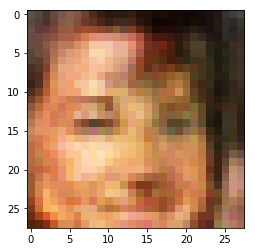

Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.8615


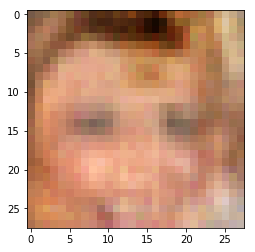

Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.8862


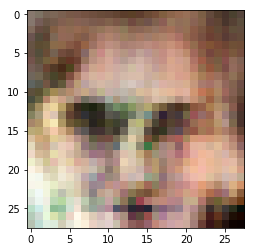

Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7685


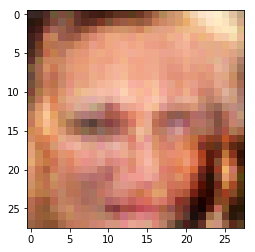

Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.7602


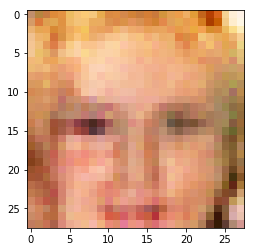

Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.7491


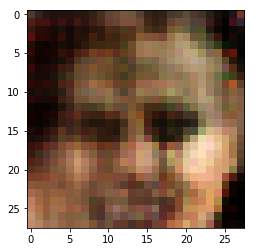

Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.8174


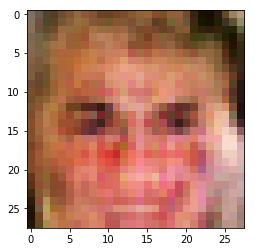

Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.8502


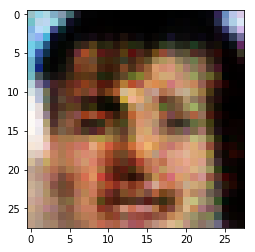

Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 0.7941


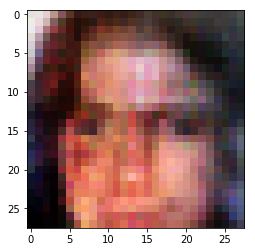

Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.7631


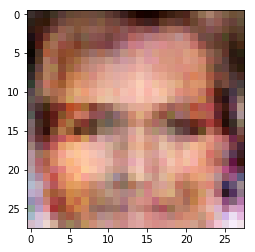

Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.7255


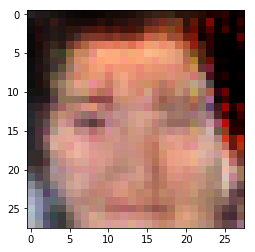

Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.7946


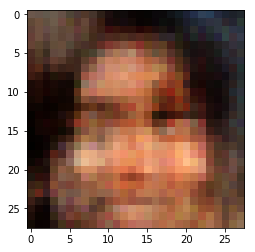

Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.7692


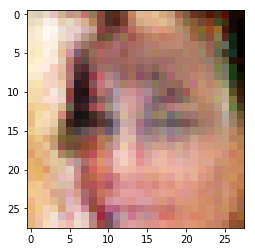

Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.7405


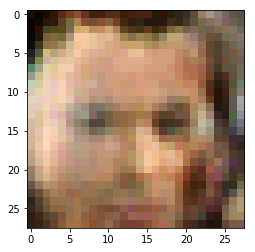

Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.7367


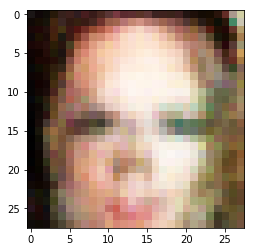

Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.7450


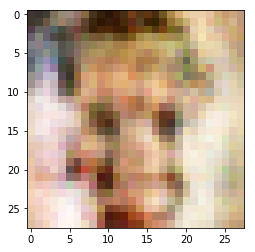

Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7912


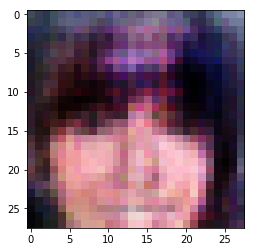

Epoch 1/1... Discriminator Loss: 1.1291... Generator Loss: 1.2059


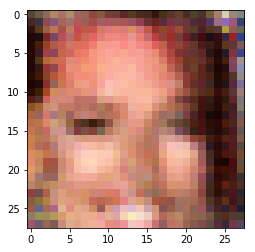

Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.7819


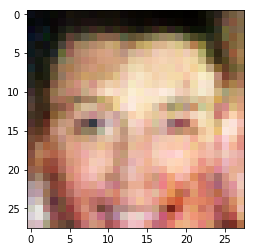

Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.7155


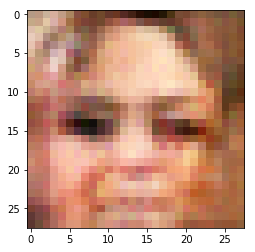

Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.7389


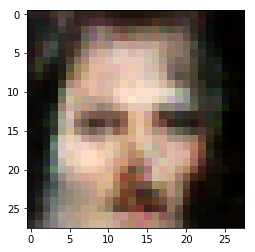

Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.7876


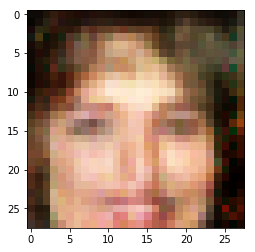

Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.7500


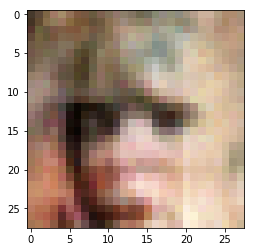

Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.8224


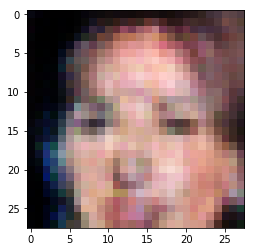

Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.7738


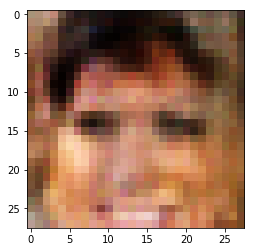

Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.7277


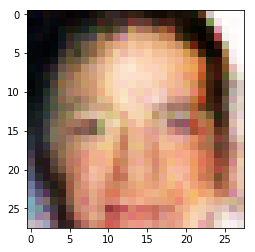

Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.7503


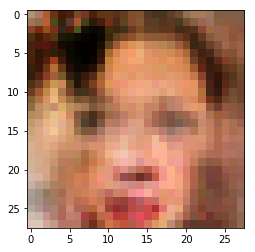

Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.7793


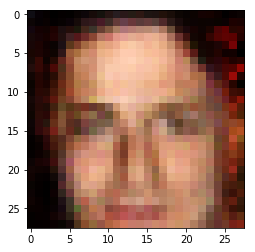

Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 1.0687


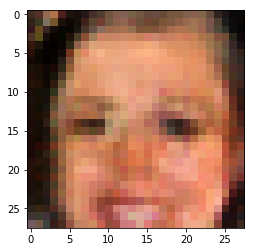

Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.7219


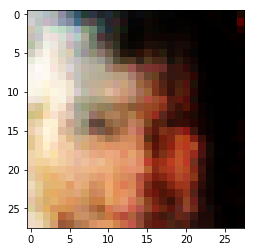

Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.6583


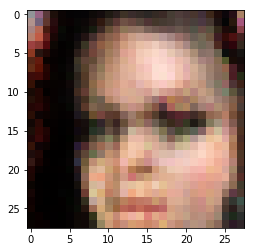

Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.7732


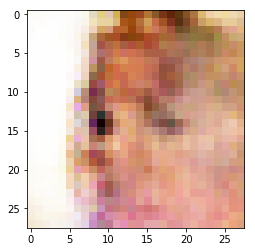

Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.7019


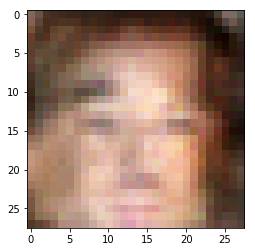

Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.7798


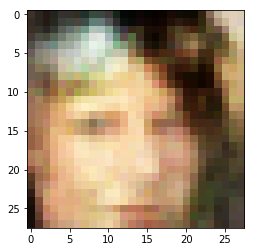

Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.9121


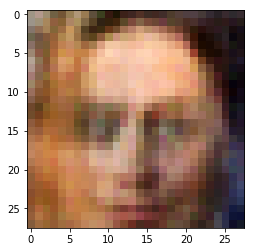

Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.8420


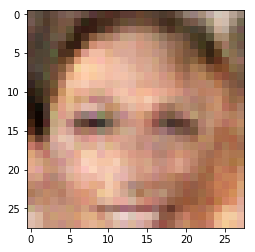

Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.8371


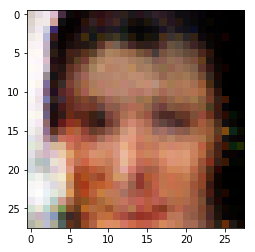

Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.9880


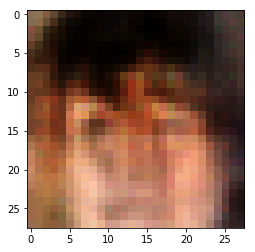

Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.8267


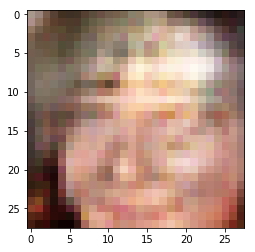

Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.8043


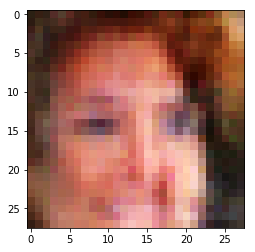

Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.8089


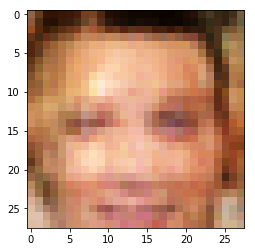

Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.7263


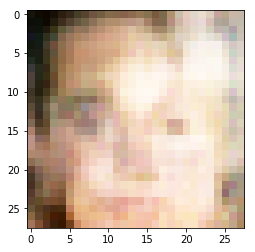

Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.6733


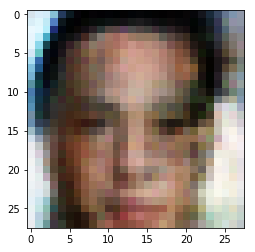

Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.6946


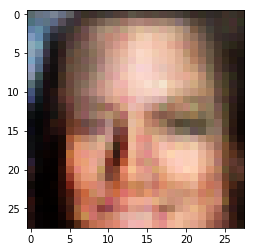

Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.7147


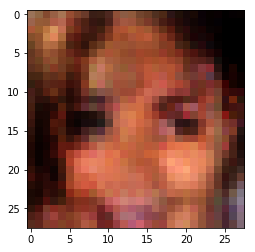

Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.7824


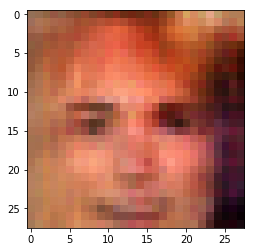

Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 1.0828


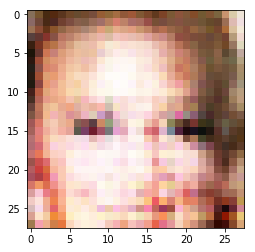

Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.9983


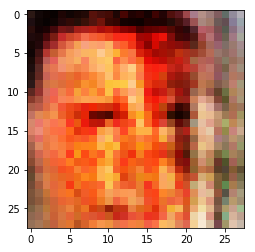

Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.8037


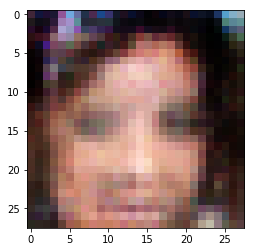

Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.6803


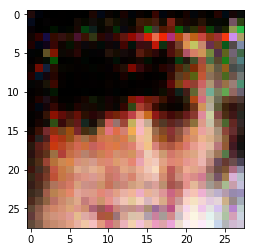

Epoch 1/1... Discriminator Loss: 1.5228... Generator Loss: 0.5017


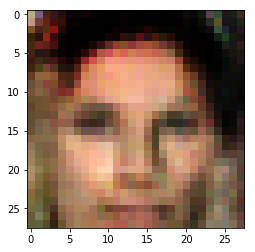

Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.7829


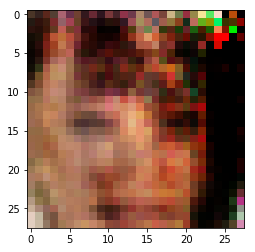

Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.8249


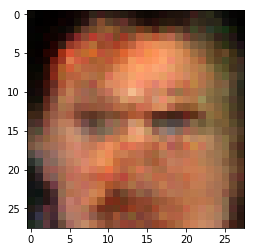

Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.7893


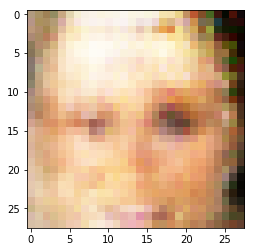

Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.7777


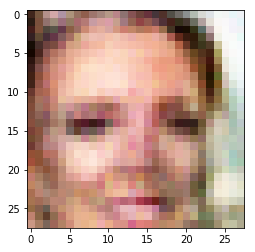

Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.6041


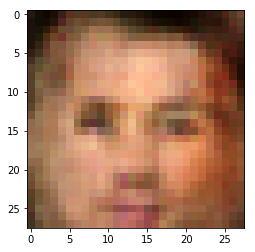

Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.7681


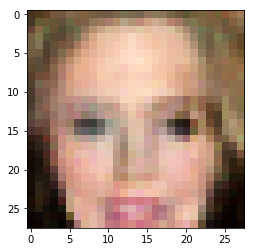

Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.7201


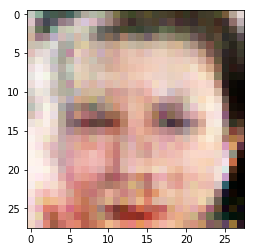

Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.7047


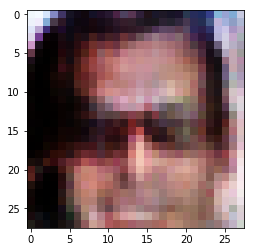

Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.7829


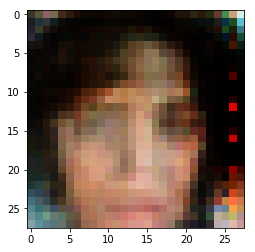

Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.8145


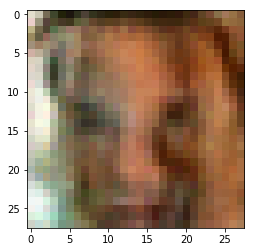

Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.8100


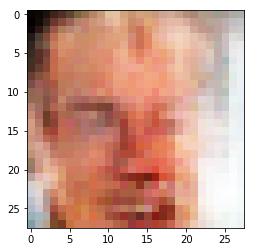

Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.7567


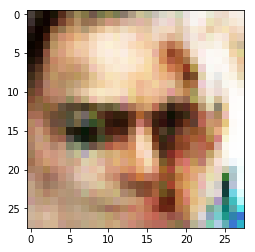

Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.8024


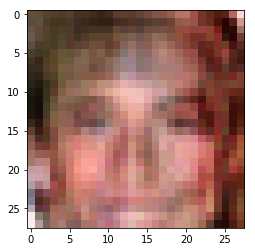

Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.7474


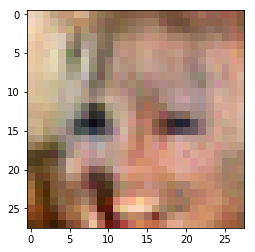

Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.7760


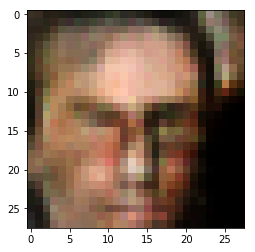

Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.7324


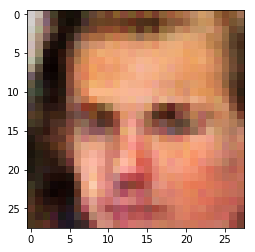

Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.7240


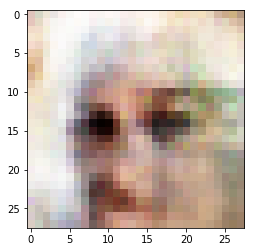

Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7291


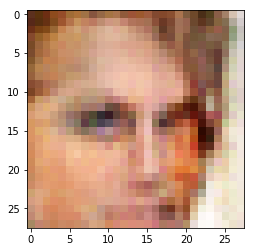

Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.7833


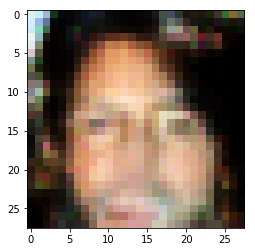

Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.7225


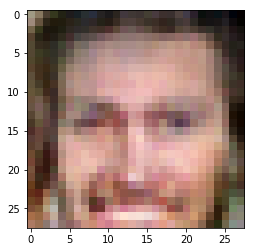

Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.7693


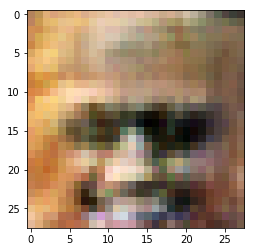

Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.6852


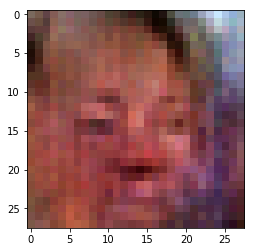

Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.6850


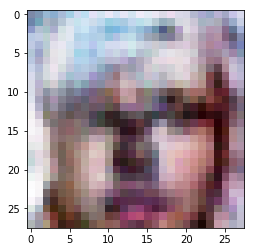

Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.6479


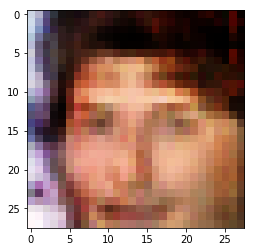

Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.7542


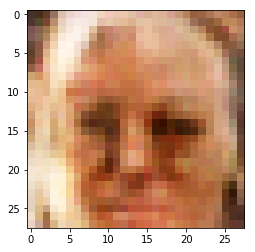

Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.7280


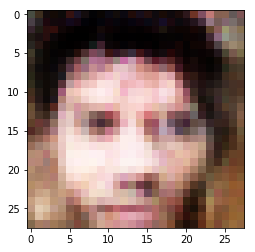

Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.7932


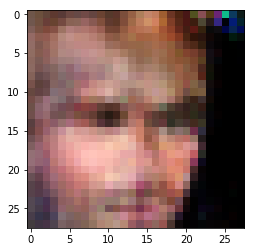

Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.7873


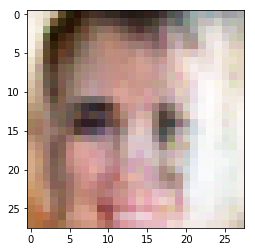

Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.8050


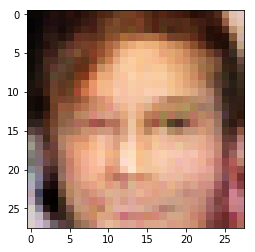

Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.8163


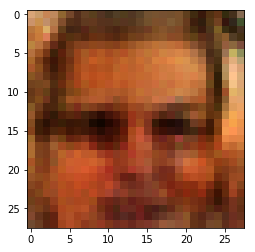

Epoch 1/1... Discriminator Loss: 1.2276... Generator Loss: 0.8848


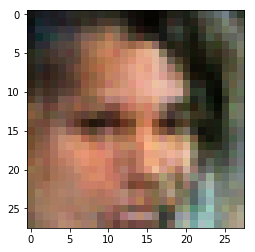

Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.7164


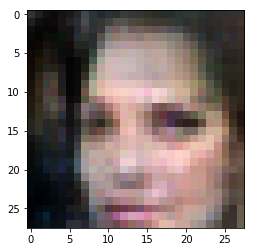

Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.7980


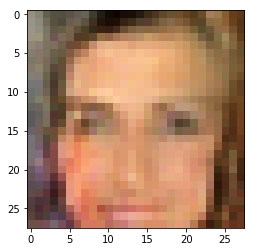

Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 0.8379


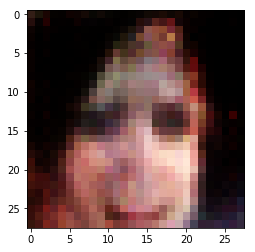

Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.7702


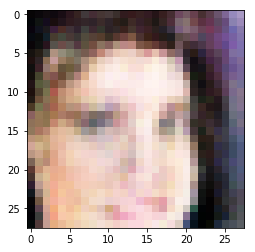

Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.7859


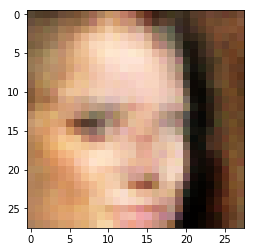

Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.6859


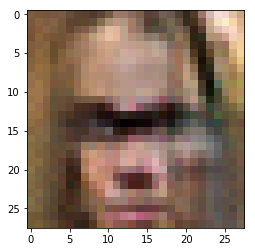

Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.7690


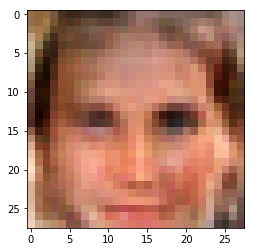

Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.8552


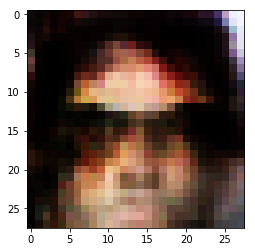

Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 1.1643


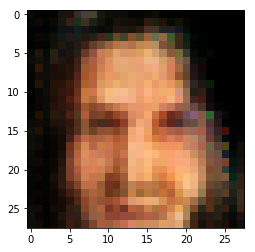

Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 1.0571


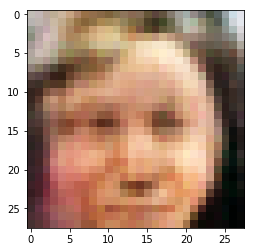

Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.6094


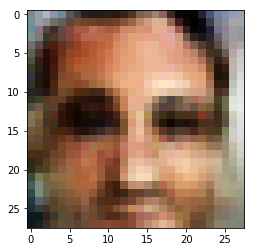

Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.7418


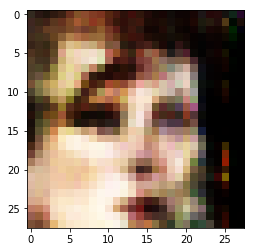

Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.7662


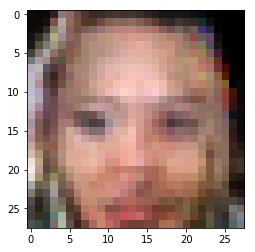

Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.5998


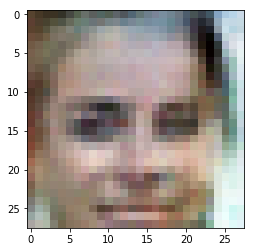

Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.8621


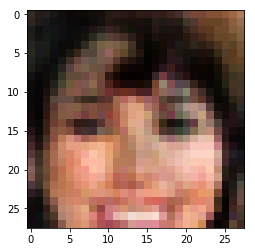

Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.6722


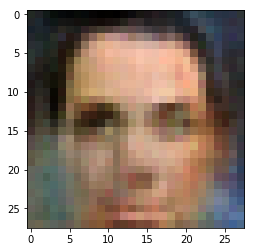

Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 0.7095


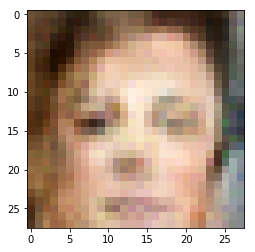

Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 1.0717


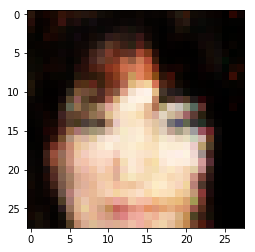

Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.5775


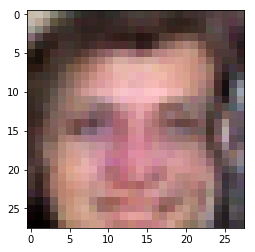

Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.6433


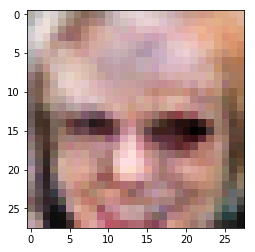

Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.6447


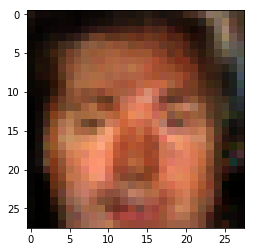

Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.9098


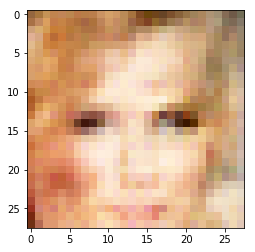

Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.7918


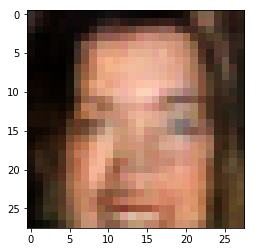

Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.7404


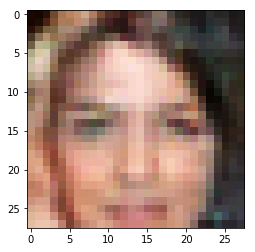

Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.8843


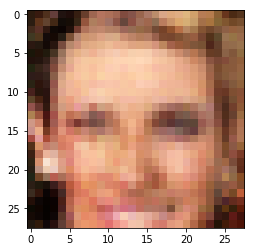

Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 0.7514


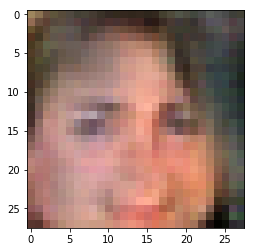

Epoch 1/1... Discriminator Loss: 1.6045... Generator Loss: 0.4281


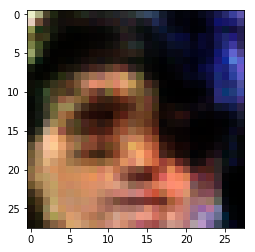

Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.7800


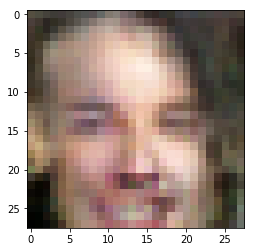

Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.6075


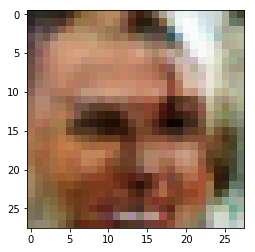

Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.6986


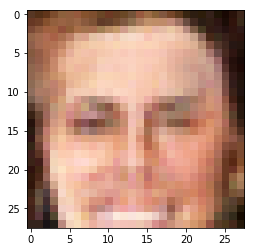

Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.7961


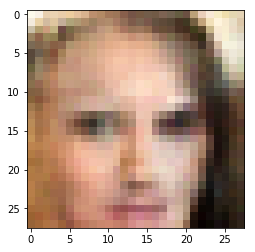

Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.7568


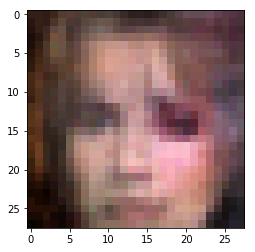

Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.6699


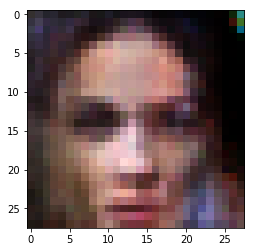

Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.5772


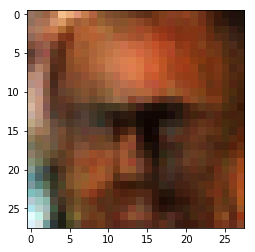

Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.5230


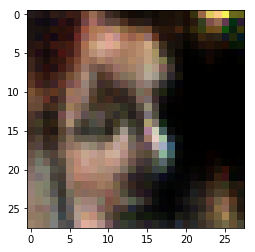

Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.7328


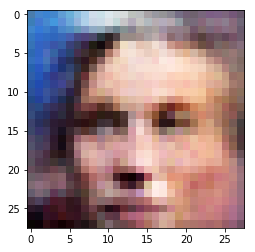

Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.6632


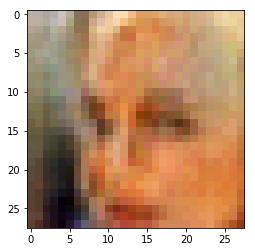

Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.8224


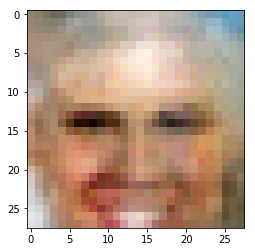

Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.7731


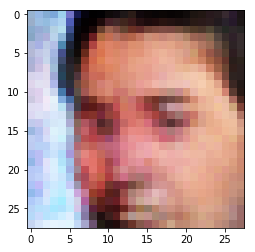

Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.6612


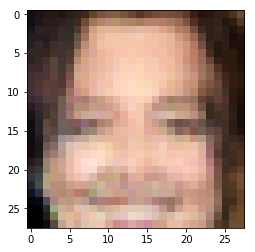

Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.6983


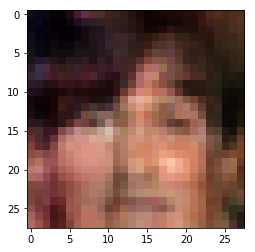

Epoch 1/1... Discriminator Loss: 1.0487... Generator Loss: 1.3279


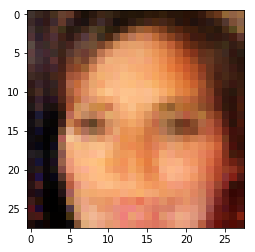

Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.7473


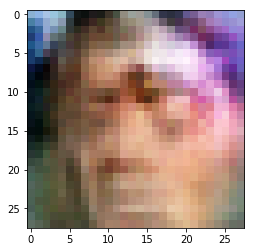

Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.5640


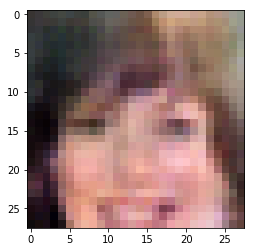

Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.6771


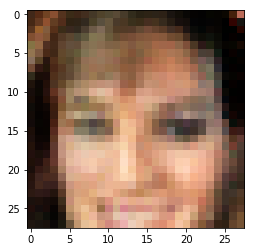

Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.6480


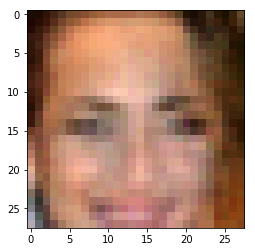

Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.9931


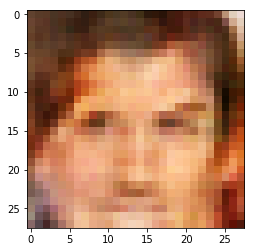

Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 1.0279


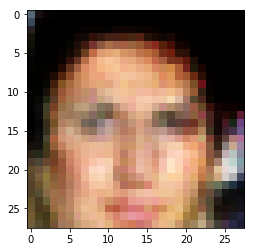

Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.8374


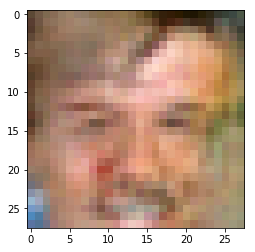

Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.6537


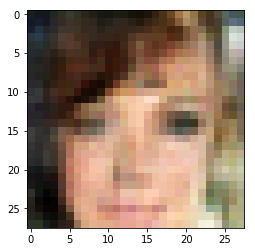

Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6546


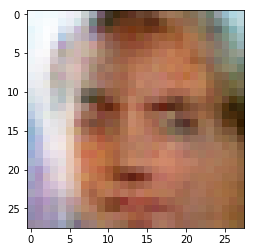

Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7182


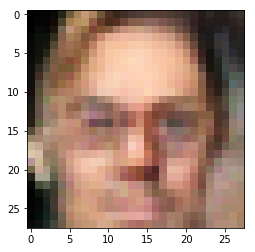

Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 1.0239


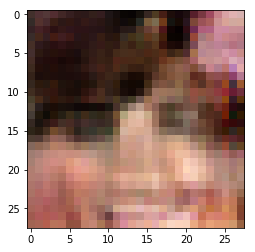

Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.6434


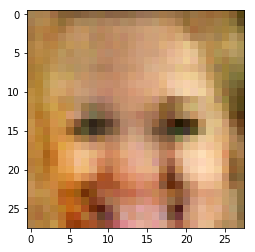

Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.7731


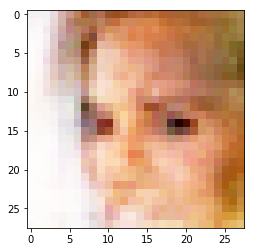

Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 0.6755


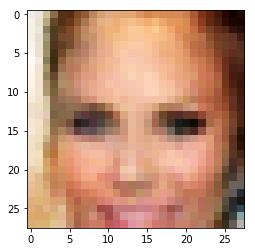

Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.6903


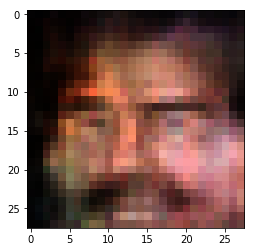

Epoch 1/1... Discriminator Loss: 1.7249... Generator Loss: 0.4110


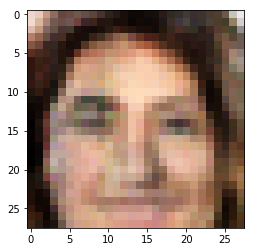

Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.8100


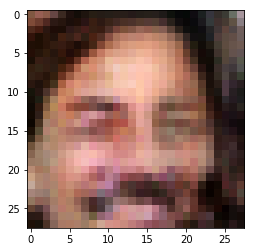

Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7515


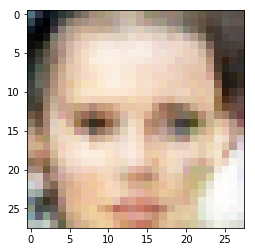

Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.6457


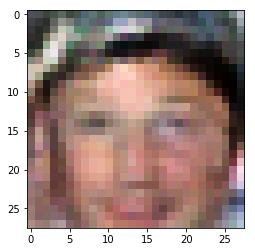

Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.7313


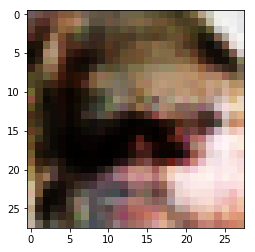

Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.7295


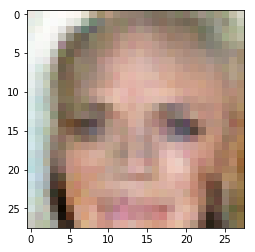

Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7345


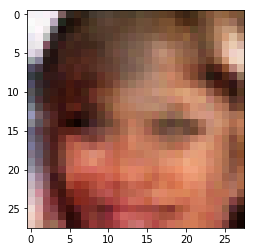

Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.8124


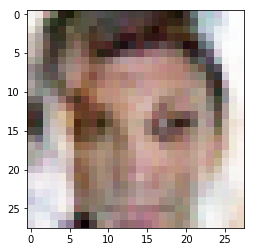

Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.6768


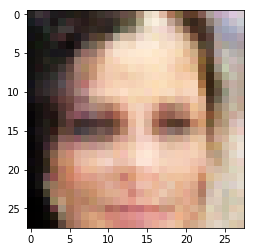

Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7575


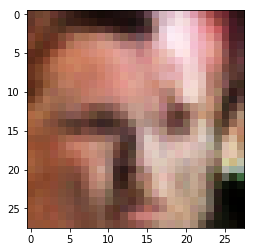

Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.8929


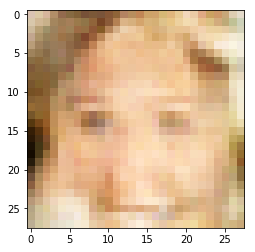

Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.6208


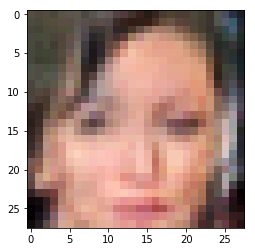

Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.7617


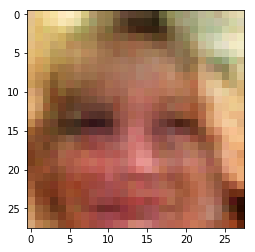

Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.8129


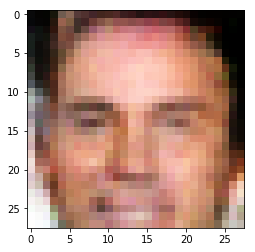

Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.7370


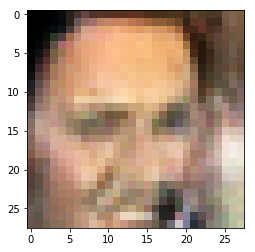

Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.6700


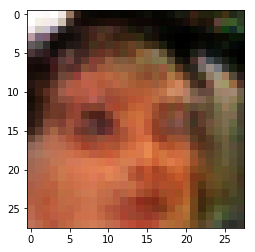

Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.6678


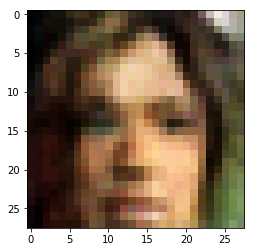

Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.6784


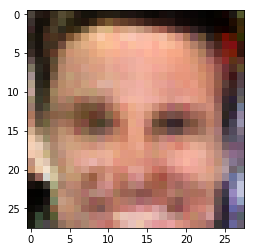

Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.6667


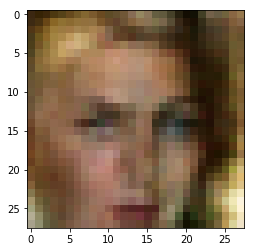

Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.6982


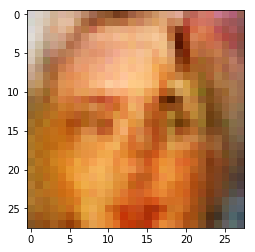

Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 0.8365


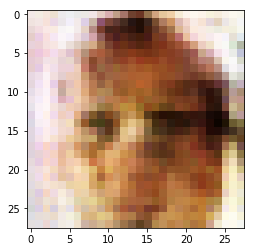

Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.6054


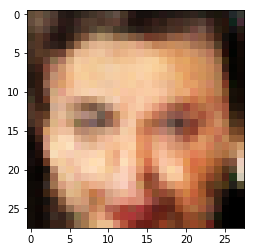

Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.7630


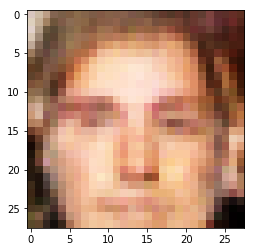

Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.7703


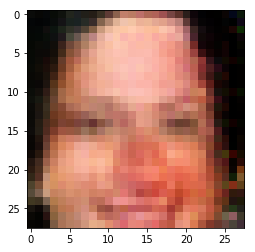

Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.6369


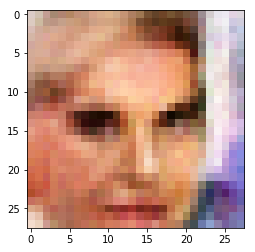

Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.6849


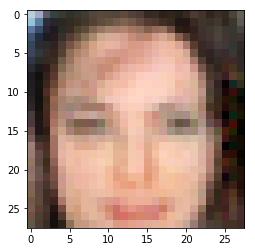

Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.7268


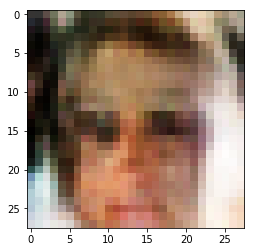

Epoch 1/1... Discriminator Loss: 1.7308... Generator Loss: 0.4579


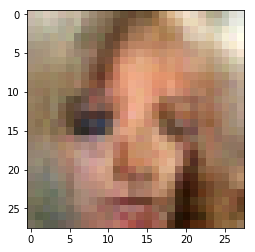

Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.7570


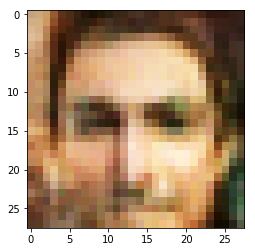

Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7517


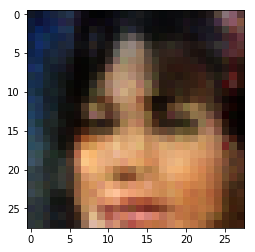

Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.7047


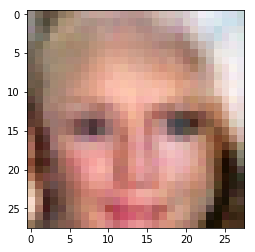

Epoch 1/1... Discriminator Loss: 1.2611... Generator Loss: 0.6965


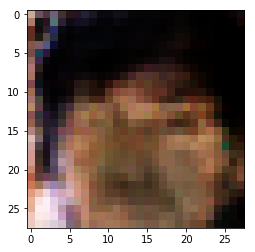

Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.6470


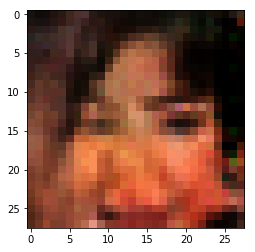

Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.7229


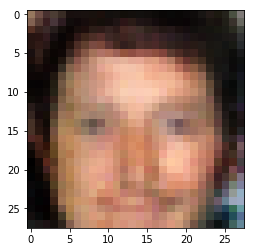

Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.6584


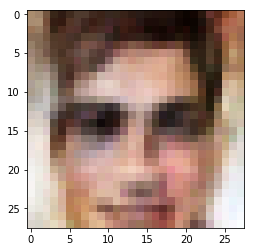

Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.7814


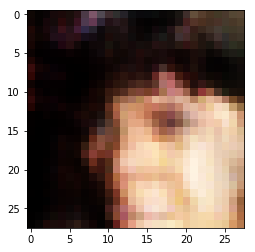

Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.7449


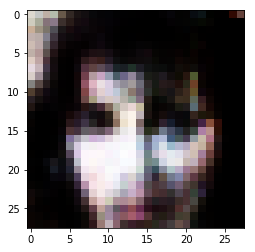

Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7093


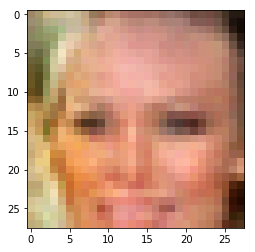

Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.7319


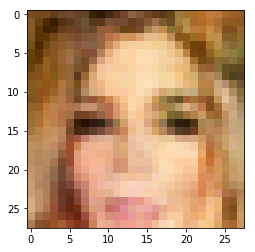

Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.6123


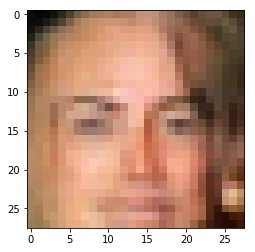

Epoch 1/1... Discriminator Loss: 1.5094... Generator Loss: 0.8424


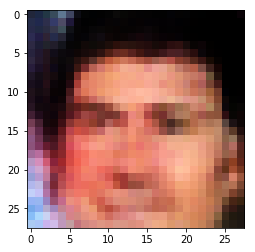

Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.5756


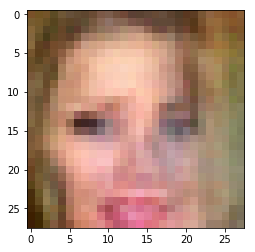

Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.6744


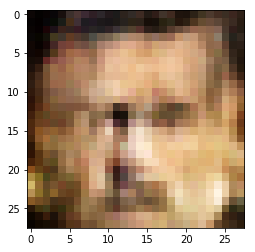

Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.8706


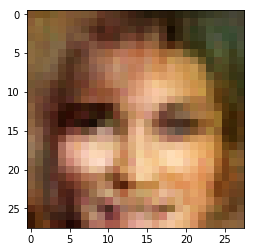

Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.7973


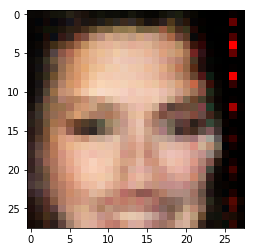

Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.7098


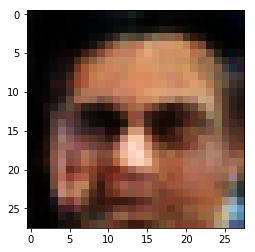

Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 0.7558


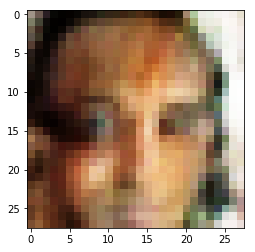

Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.7594


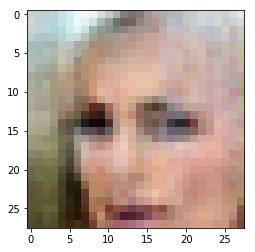

Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.7469


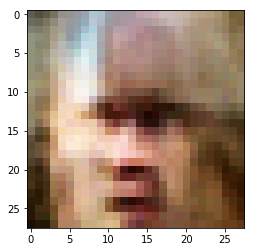

Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.7258


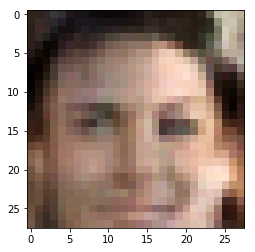

Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.7062


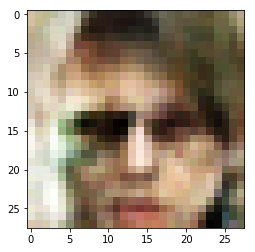

Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.8563


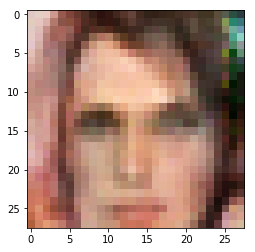

Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.7395


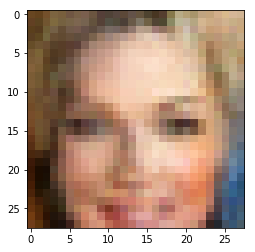

Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.6756


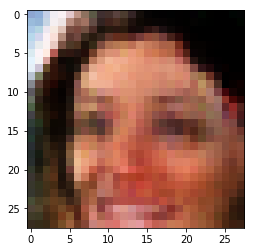

Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.6280


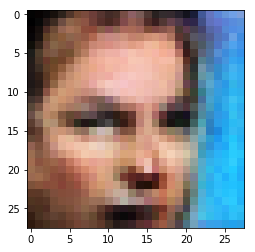

Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.7228


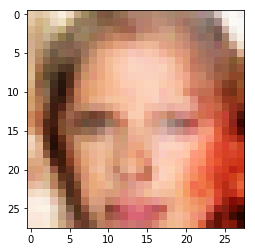

Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.6565


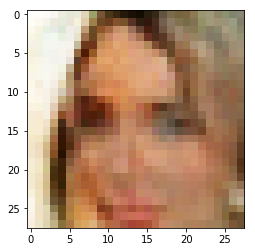

Epoch 1/1... Discriminator Loss: 1.5206... Generator Loss: 0.6184


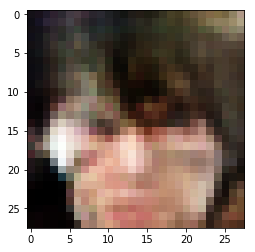

Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.7618


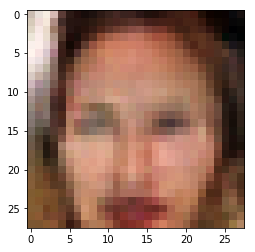

Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.6496


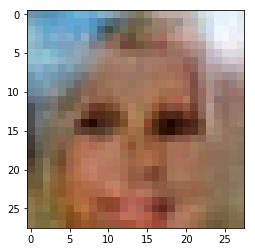

Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.7979


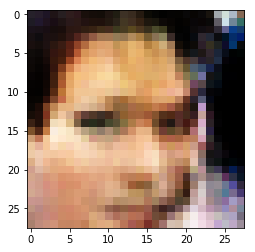

Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.8037


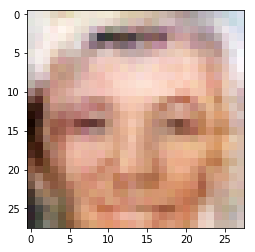

Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.6224


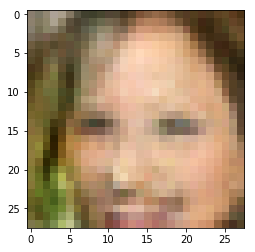

Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 1.0394


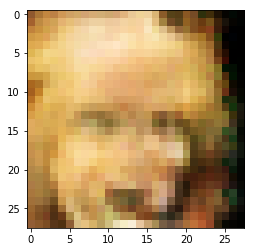

Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.7252


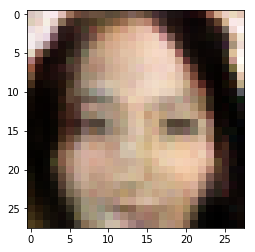

Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 0.5613


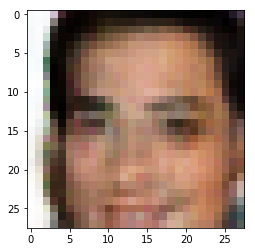

Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.8190


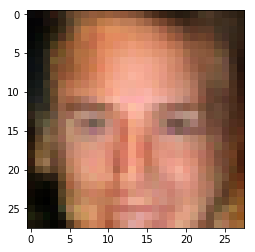

Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7458


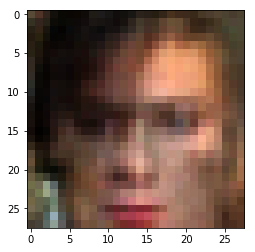

Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 0.6120


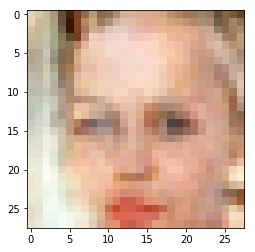

Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.6319


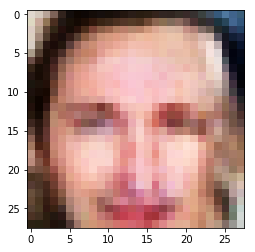

Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.7249


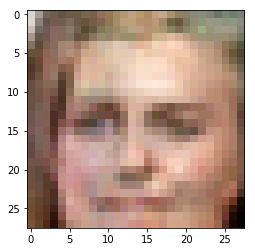

Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.6380


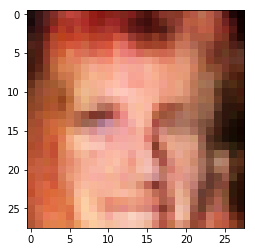

Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 1.3046


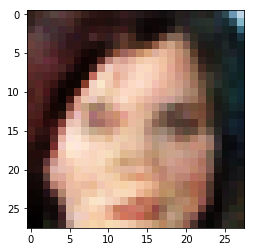

Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.6469


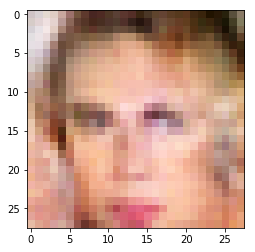

Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.5844


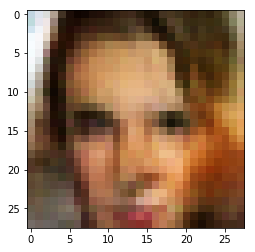

Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.7004


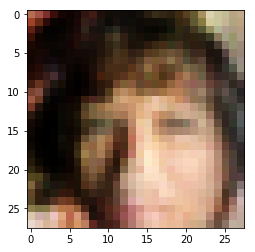

Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 0.7793


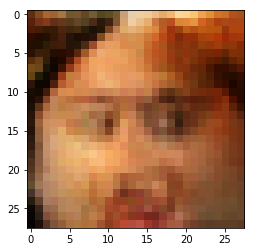

Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.8608


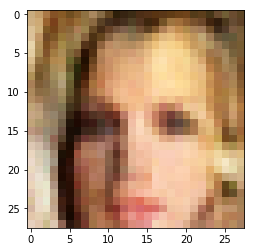

Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.7172


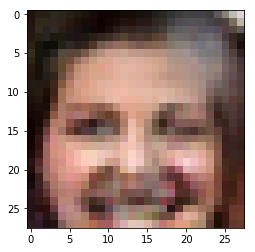

Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.6698


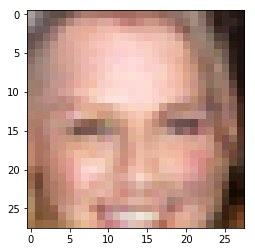

Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.8198


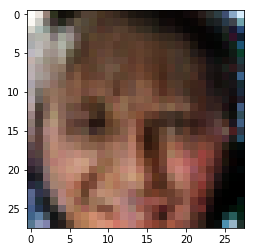

Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.6123


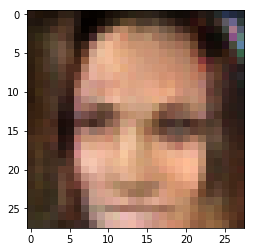

Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.5454


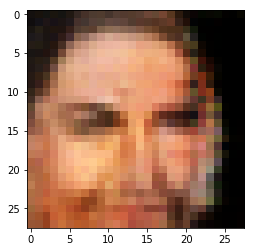

Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.7033


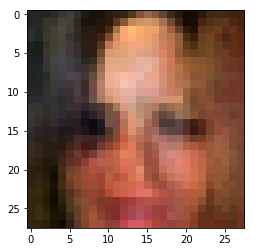

Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.6230


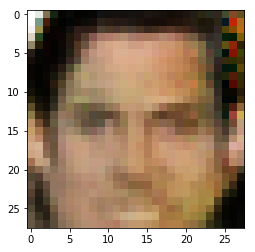

Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.7012


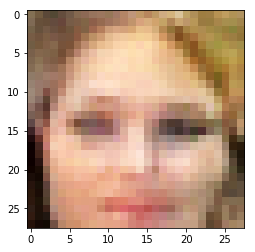

Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.7487


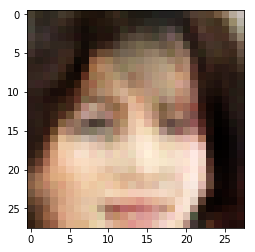

Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.7412


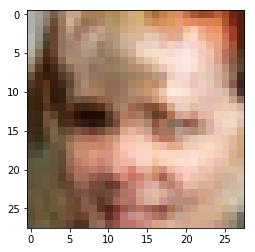

Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.8398


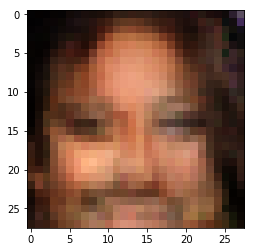

Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.9232


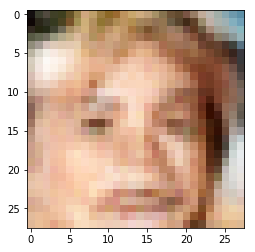

Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.7421


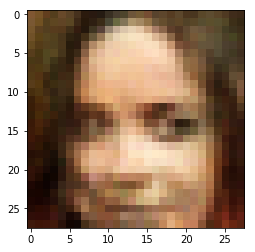

Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.8112


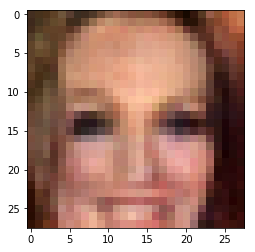

Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.7363


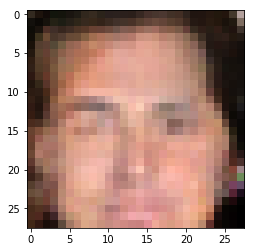

Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.6796


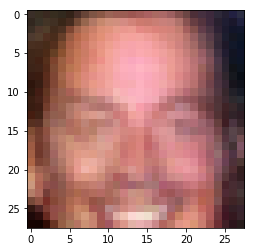

Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 0.8676


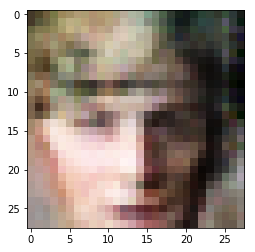

Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.6776


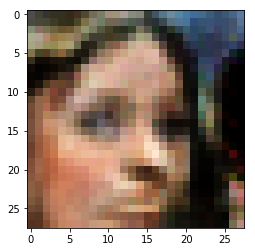

Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.5394


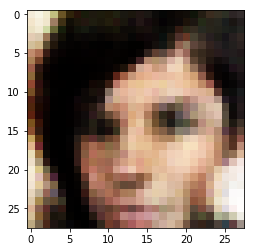

Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.6845


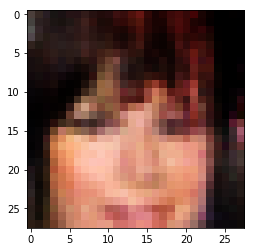

Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.9154


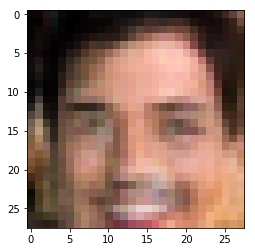

Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 0.8173


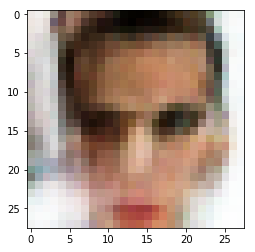

Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.7507


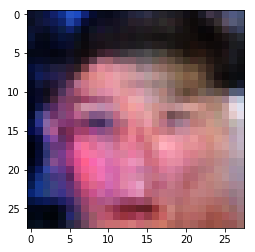

In [41]:
batch_size = 64
z_dim = 100
learning_rate = 0.0006
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.